### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
ls /ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_6/alabama/2022_12_09_11_52_20/count_data/

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
population.csv                   ylds.hdf
population.hdf                   ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_6/alabama/2022_12_09_11_52_20/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

Unnamed: 0     sex  year                  cause measure  input_draw  \
0           0  female  2023  acute_ischemic_stroke  deaths          29   
1           1  female  2023  acute_ischemic_stroke  deaths          29   
2           2  female  2023  acute_ischemic_stroke  deaths          29   
3           3  female  2023  acute_ischemic_stroke  deaths          29   
4           4  female  2023  acute_ischemic_stroke  deaths          29   

   scenario       age  value  
0  baseline  25_to_29      2  
1  baseline  30_to_34      1  
2  baseline  35_to_39      0  
3  baseline  40_to_44      0  
4  baseline  45_to_49      1

In [5]:
pop = pd.read_csv(sim_results_dir + 'population.csv')
pop.loc[pop.measure=="total_population_untracked"].value.sum()
pop.head()

Unnamed: 0           measure  input_draw  scenario   value
0           0  total_population          29  baseline  750000
1           1  total_population         232  baseline  750000
2           2  total_population         357  baseline  750000
3           3  total_population         394  baseline  750000
4           4  total_population         602  baseline  750000

In [6]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [7]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

102356373.9247091

In [8]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
person_time_test.value.sum()

102356373.92470908

### Total DALYs by Year

In [9]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

sex       age  input_draw  year          yll        yld         daly
0  female  25_to_29          29  2023  1979.294558  53.262302  2032.556860
1  female  25_to_29          29  2024  2777.078392  54.382161  2831.460554
2  female  25_to_29          29  2025  2710.006808  54.089027  2764.095835
3  female  25_to_29          29  2026  3143.895659  54.954009  3198.849669
4  female  25_to_29          29  2027  2144.669234  56.634060  2201.303294

In [10]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

year         mean        2.5%         97.5%
0  2023  6021.783868  730.001446  12753.989644
1  2024  6142.737029  778.221067  12750.880406
2  2025  6138.349451  836.843407  12786.217359
3  2026  6193.159716  857.202500  13046.550346
4  2027  6258.491055  912.951963  13188.227387

### All Cause Mortality Graphs

In [11]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

age     sex  year   mean  2.5%   97.5%
0  25_to_29  female  2023  13.66   0.0  89.800
1  25_to_29  female  2024  13.64   0.0  75.100
2  25_to_29  female  2025  12.60   0.0  68.775
3  25_to_29  female  2026  12.80   0.0  57.150
4  25_to_29  female  2027  12.28   0.0  49.950

#### All Cause Mortality Graph with Rate

In [12]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

age     sex  year  input_draw       ptvalue
0  25_to_29  female  2023          29  27441.839836
1  25_to_29  female  2023         232  27756.911704
2  25_to_29  female  2023         357  27624.366872
3  25_to_29  female  2023         394  27463.457906
4  25_to_29  female  2023         602  27322.097194

In [13]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.002495  0.000927  0.007163
1  25_to_29  female  2024  0.002521  0.000891  0.006671
2  25_to_29  female  2025  0.002355  0.001149  0.006101
3  25_to_29  female  2026  0.002405  0.000984  0.006695
4  25_to_29  female  2027  0.002317  0.001009  0.006447

### Cause Specific Mortality Graphs
#### Acute Stroke

In [14]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

index       age     sex  year                  cause  mean  2.5%   97.5%
0      0  25_to_29  female  2023  acute_ischemic_stroke   2.6   0.0  16.725
1      5  25_to_29  female  2024  acute_ischemic_stroke   3.7   0.0  17.625
2     10  25_to_29  female  2025  acute_ischemic_stroke   2.4   0.0  13.425
3     15  25_to_29  female  2026  acute_ischemic_stroke   2.9   0.0  18.950
4     20  25_to_29  female  2027  acute_ischemic_stroke   2.9   0.0  18.500

In [15]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

index       age     sex  year  input_draw                  cause  value
0      0  25_to_29  female  2023          29  acute_ischemic_stroke      2
1      5  25_to_29  female  2023         232  acute_ischemic_stroke      0
2     10  25_to_29  female  2023         357  acute_ischemic_stroke      1
3     15  25_to_29  female  2023         394  acute_ischemic_stroke      0
4     20  25_to_29  female  2023         602  acute_ischemic_stroke      0

In [16]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

age     sex  year      mean  2.5%     97.5%
0  25_to_29  female  2023  0.000095   0.0  0.000612
1  25_to_29  female  2024  0.000137   0.0  0.000652
2  25_to_29  female  2025  0.000089   0.0  0.000501
3  25_to_29  female  2026  0.000109   0.0  0.000712
4  25_to_29  female  2027  0.000110   0.0  0.000699

#### Chronic Stroke

In [17]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

age     sex  year      mean      2.5%     97.5%
0    25_to_29  female  2023  0.000000  0.000000  0.000000
1    25_to_29  female  2024  0.000000  0.000000  0.000000
2    25_to_29  female  2025  0.000000  0.000000  0.000000
3    25_to_29  female  2026  0.000000  0.000000  0.000000
..        ...     ...   ...       ...       ...       ...
536   95_plus    male  2037  0.009785  0.003199  0.013252
537   95_plus    male  2038  0.008734  0.002326  0.017576
538   95_plus    male  2039  0.009130  0.005927  0.014051
539   95_plus    male  2040  0.007935  0.004177  0.010425

[540 rows x 6 columns]

#### Acute Myocardial Infarction

In [18]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'chronic_ischemic_stroke', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [19]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_rate = pd.concat([acute_MI_rate, per_time_group.ptvalue], axis=1)
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.001168  0.000008  0.004591
1  25_to_29  female  2024  0.001009  0.000045  0.004015
2  25_to_29  female  2025  0.000971  0.000119  0.003536
3  25_to_29  female  2026  0.000946  0.000149  0.003948
4  25_to_29  female  2027  0.000810  0.000084  0.003483

#### Post Myocaridal Infarction

In [20]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.000285  0.000045  0.000911
1  25_to_29  female  2024  0.000341  0.000074  0.001166
2  25_to_29  female  2025  0.000371  0.000054  0.001210
3  25_to_29  female  2026  0.000380  0.000083  0.001080
4  25_to_29  female  2027  0.000409  0.000008  0.001332

### Excess Mortality rate

#### Post Myocardial Infarction

In [22]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.042094  0.020631  0.073615
1  25_to_29  female  2024  0.044928  0.021592  0.064233
2  25_to_29  female  2025  0.051704  0.024815  0.131698
3  25_to_29  female  2026  0.054053  0.031423  0.087944
4  25_to_29  female  2027  0.044743  0.003744  0.088357

### Prevalence 

#### Chronic + Acute Stroke

In [23]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

age     sex  year      mean          2.5%     97.5%
0  25_to_29  female  2023  0.000299  2.767322e-06  0.001461
1  25_to_29  female  2024  0.000298  3.441543e-06  0.001425
2  25_to_29  female  2025  0.000285  6.940376e-06  0.001396
3  25_to_29  female  2026  0.000278  3.496770e-06  0.001419
4  25_to_29  female  2027  0.000252  6.441325e-07  0.001318

In [24]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

#### Myocardial Infarction

In [25]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = pd.concat([prev_acute_MI, per_time_group.ptvalue], axis=1)
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.000407  0.000038  0.001560
1  25_to_29  female  2024  0.000369  0.000049  0.001424
2  25_to_29  female  2025  0.000360  0.000056  0.001382
3  25_to_29  female  2026  0.000344  0.000045  0.001442
4  25_to_29  female  2027  0.000307  0.000037  0.001328

In [26]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.006744  0.001461  0.021061
1  25_to_29  female  2024  0.007462  0.001513  0.023478
2  25_to_29  female  2025  0.007994  0.001544  0.024112
3  25_to_29  female  2026  0.008369  0.001549  0.024080
4  25_to_29  female  2027  0.008538  0.001440  0.023711

### Incidence of First Time Acute Ischemic Stroke

In [28]:
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [29]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

index       age     sex  year  \
0      2  25_to_29  female  2023   
1      8  25_to_29  female  2024   
2     14  25_to_29  female  2025   
3     20  25_to_29  female  2026   
4     26  25_to_29  female  2027   

                                          transition  mean   2.5%    97.5%  
0  ischemic_stroke_susceptible_to_ischemic_stroke...  43.9  1.225  243.975  
1  ischemic_stroke_susceptible_to_ischemic_stroke...  40.7  1.000  226.550  
2  ischemic_stroke_susceptible_to_ischemic_stroke...  39.5  2.225  214.150  
3  ischemic_stroke_susceptible_to_ischemic_stroke...  36.6  1.450  209.950  
4  ischemic_stroke_susceptible_to_ischemic_stroke...  34.7  0.225  199.750

In [30]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

index       age     sex  year  \
0     20  25_to_29  female  2023   
1     21  25_to_29  female  2023   
2     22  25_to_29  female  2023   
3     23  25_to_29  female  2023   
4     24  25_to_29  female  2023   

                                            state  input_draw       ptvalue  
0  ischemic_stroke_susceptible_to_ischemic_stroke          29  27134.740589  
1  ischemic_stroke_susceptible_to_ischemic_stroke         232  27616.010951  
2  ischemic_stroke_susceptible_to_ischemic_stroke         357  27449.429158  
3  ischemic_stroke_susceptible_to_ischemic_stroke         394  27295.802875  
4  ischemic_stroke_susceptible_to_ischemic_stroke         602  27150.455852

In [31]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.001604  0.000044  0.008920
1  25_to_29  female  2024  0.001505  0.000037  0.008381
2  25_to_29  female  2025  0.001475  0.000082  0.007999
3  25_to_29  female  2026  0.001374  0.000054  0.007881
4  25_to_29  female  2027  0.001311  0.000008  0.007547

### Incidence of Acute Myocardial Infraction 

In [32]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction','myocardial_infarction_post_myocardial_infarction']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.005255  0.000485  0.020309
                2024  0.004889  0.000629  0.019142
                2025  0.004768  0.000752  0.018262
                2026  0.004481  0.000510  0.019042
                2027  0.003962  0.000483  0.017243

### Artifacts

In [34]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  raw_data/  washington.hdf


In [35]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [36]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

location     sex  age_start  age_end  year_start  year_end          value
0  Alabama  Female       25.0     30.0        2019      2020  171101.787730
1  Alabama  Female       30.0     35.0        2019      2020  162707.127245
2  Alabama  Female       35.0     40.0        2019      2020  160738.561697
3  Alabama  Female       40.0     45.0        2019      2020  151811.937430
4  Alabama  Female       45.0     50.0        2019      2020  160780.871213

In [37]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [38]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

sex  age_start  age_end  year_start  year_end   draw_0   draw_1  \
0  Female       25.0     30.0        2019      2020  0.31588  0.40003   
1  Female       30.0     35.0        2019      2020  0.30193  0.33175   
2  Female       35.0     40.0        2019      2020  0.28018  0.29485   
3  Female       40.0     45.0        2019      2020  0.24315  0.27495   
4  Female       45.0     50.0        2019      2020  0.19085  0.27205   

    draw_2   draw_3   draw_4  ...  draw_990  draw_991  draw_992  draw_993  \
0  0.32045  0.38893  0.24140  ...   0.27915   0.29902   0.33340   0.28170   
1  0.28828  0.37140  0.24475  ...   0.27680   0.29742   0.35445   0.23455   
2  0.27522  0.29580  0.32445  ...   0.29240   0.29728   0.32355   0.24025   
3  0.29525  0.26428  0.35000  ...   0.28105   0.31522   0.29495   0.24098   
4  0.34835  0.27682  0.32140  ...   0.24275   0.35128   0.26865   0.23673   

   draw_994  draw_995  draw_996  draw_997  draw_998  draw_999  
0   0.45043   0.26388   0.31837   0.28815   0.23798   0.20685  
1   0.42553   0.22783   0.26775   0.28548   0.25033   0.25325  
2   0.35158   0.27568   0.30525   0.40163   0.30818   0.44195  
3   0.31315   0.28515   0.32320   0.41060   0.31078   0.45695  
4   0.31025   0.25625   0.32160   0.31240   0.25812   0.29825  

[5 rows x 1005 columns]

In [39]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [40]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000950  0.000706   
1  female       30.0     35.0        2019      2020  0.001364  0.001029   
2  female       35.0     40.0        2019      2020  0.001697  0.001285   
3  female       40.0     45.0        2019      2020  0.002592  0.001978   
4  female       45.0     50.0        2019      2020  0.003660  0.002792   

      97.5% location                        measure age_group  
0  0.001237  Alabama  cause_specific_mortality_rate  25_to_29  
1  0.001755  Alabama  cause_specific_mortality_rate  30_to_34  
2  0.002179  Alabama  cause_specific_mortality_rate  35_to_39  
3  0.003305  Alabama  cause_specific_mortality_rate  40_to_44  
4  0.004668  Alabama  cause_specific_mortality_rate  45_to_49

In [41]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.002269  0.000931  0.007133
1  25_to_29    male  0.002620  0.001801  0.003668
2  30_to_34  female  0.001805  0.001012  0.002766
3  30_to_34    male  0.002655  0.001959  0.003417
4  35_to_39  female  0.001912  0.001293  0.002602

### Cause Specific Mortality Rates

#### Stroke

In [42]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000002  0.000001   
1  female       30.0     35.0        2019      2020  0.000004  0.000002   
2  female       35.0     40.0        2019      2020  0.000006  0.000003   
3  female       40.0     45.0        2019      2020  0.000011  0.000007   
4  female       45.0     50.0        2019      2020  0.000017  0.000011   

      97.5% location                        measure age_group  
0  0.000003  Alabama  cause_specific_mortality_rate  25_to_29  
1  0.000007  Alabama  cause_specific_mortality_rate  30_to_34  
2  0.000009  Alabama  cause_specific_mortality_rate  35_to_39  
3  0.000016  Alabama  cause_specific_mortality_rate  40_to_44  
4  0.000026  Alabama  cause_specific_mortality_rate  45_to_49

In [43]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [44]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [45]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [46]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

age     sex      mean  2.5%     97.5%
0  25_to_29  female  0.000093   0.0  0.000773
1  25_to_29    male  0.000020   0.0  0.000161
2  30_to_34  female  0.000026   0.0  0.000186
3  30_to_34    male  0.000008   0.0  0.000039
4  35_to_39  female  0.000013   0.0  0.000077

#### Myocardial Infarction

In [47]:
art_csmr2 = load_artifact_data('cause', 'myocardial_infarction', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000017  0.000012   
1  female       30.0     35.0        2019      2020  0.000047  0.000034   
2  female       35.0     40.0        2019      2020  0.000098  0.000072   
3  female       40.0     45.0        2019      2020  0.000232  0.000165   
4  female       45.0     50.0        2019      2020  0.000393  0.000291   

      97.5% location                        measure age_group  
0  0.000024  Alabama  cause_specific_mortality_rate  25_to_29  
1  0.000064  Alabama  cause_specific_mortality_rate  30_to_34  
2  0.000132  Alabama  cause_specific_mortality_rate  35_to_39  
3  0.000311  Alabama  cause_specific_mortality_rate  40_to_44  
4  0.000513  Alabama  cause_specific_mortality_rate  45_to_49

In [48]:
acute_MI_rate_allyear = (acute_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [49]:
post_MI_rate_allyear = (post_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [50]:
acute_MI_rate = acute_MI_rate.rename(columns = {'mean_rate':'acute_rate'})
post_MI_rate = post_MI_rate.rename(columns = {'mean_rate':'post_rate'})
total_MI_rate = pd.concat([acute_MI_rate, post_MI_rate.post_rate], axis=1)
total_MI_rate['total_rate'] = total_MI_rate['acute_rate'] + total_MI_rate['post_rate']
total_MI_rate_allyear = (total_MI_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_MI_rate_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.001242  0.000144  0.005468
1  25_to_29    male  0.000467  0.000123  0.001369
2  30_to_34  female  0.000457  0.000076  0.001032
3  30_to_34    male  0.000284  0.000073  0.000576
4  35_to_39  female  0.000253  0.000038  0.000589

#### Incidence Rates for Stroke

In [51]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000116  0.000050   
1  female       30.0     35.0        2019      2020  0.000163  0.000091   
2  female       35.0     40.0        2019      2020  0.000232  0.000128   
3  female       40.0     45.0        2019      2020  0.000370  0.000242   
4  female       45.0     50.0        2019      2020  0.000579  0.000343   

      97.5% location         measure age_group  
0  0.000225  Alabama  incidence_rate  25_to_29  
1  0.000266  Alabama  incidence_rate  30_to_34  
2  0.000381  Alabama  incidence_rate  35_to_39  
3  0.000552  Alabama  incidence_rate  40_to_44  
4  0.000939  Alabama  incidence_rate  45_to_49

In [52]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.001306  0.000000  0.009709
1  25_to_29    male  0.000097  0.000000  0.000296
2  30_to_34  female  0.000459  0.000038  0.002083
3  30_to_34    male  0.000120  0.000000  0.000352
4  35_to_39  female  0.000451  0.000056  0.001051

#### Incidence Rates for MI

In [53]:
art_inc_acute_MI = load_artifact_data('cause', 'myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000452  0.000284   
1  female       30.0     35.0        2019      2020  0.000510  0.000345   
2  female       35.0     40.0        2019      2020  0.000426  0.000296   
3  female       40.0     45.0        2019      2020  0.000540  0.000414   
4  female       45.0     50.0        2019      2020  0.000850  0.000649   

      97.5% location         measure age_group  
0  0.000616  Alabama  incidence_rate  25_to_29  
1  0.000683  Alabama  incidence_rate  30_to_34  
2  0.000581  Alabama  incidence_rate  35_to_39  
3  0.000690  Alabama  incidence_rate  40_to_44  
4  0.001110  Alabama  incidence_rate  45_to_49

In [54]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.004164  0.000623  0.017408
         male    0.000934  0.000422  0.001604
30_to_34 female  0.001270  0.000386  0.003053
         male    0.000713  0.000395  0.001183
35_to_39 female  0.000707  0.000382  0.001215

#### Prevalence Rates

In [57]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [58]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.004986  0.003708   
1  female       30.0     35.0        2019      2020  0.006119  0.004613   
2  female       35.0     40.0        2019      2020  0.007737  0.005971   
3  female       40.0     45.0        2019      2020  0.010115  0.007659   
4  female       45.0     50.0        2019      2020  0.014078  0.010695   

      97.5% location     measure age_group  
0  0.006410  Alabama  prevalence  25_to_29  
1  0.007857  Alabama  prevalence  30_to_34  
2  0.010016  Alabama  prevalence  35_to_39  
3  0.013100  Alabama  prevalence  40_to_44  
4  0.018031  Alabama  prevalence  45_to_49

In [59]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [60]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

#### Prevalence of Post MI

In [61]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.001227  0.000904   
1  female       30.0     35.0        2019      2020  0.002536  0.001865   
2  female       35.0     40.0        2019      2020  0.004012  0.003125   
3  female       40.0     45.0        2019      2020  0.005660  0.004450   
4  female       45.0     50.0        2019      2020  0.007613  0.005996   

      97.5% location     measure age_group  
0  0.001572  Alabama  prevalence  25_to_29  
1  0.003277  Alabama  prevalence  30_to_34  
2  0.005009  Alabama  prevalence  35_to_39  
3  0.007101  Alabama  prevalence  40_to_44  
4  0.009425  Alabama  prevalence  45_to_49

In [62]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.008333  0.001358  0.024563
1  25_to_29    male  0.003789  0.000985  0.014761
2  30_to_34  female  0.010086  0.002642  0.029012
3  30_to_34    male  0.004679  0.002069  0.012453
4  35_to_39  female  0.010028  0.004037  0.027615

#### Prevalence of Acute MI

In [63]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000029  0.000019   
1  female       30.0     35.0        2019      2020  0.000036  0.000024   
2  female       35.0     40.0        2019      2020  0.000031  0.000022   
3  female       40.0     45.0        2019      2020  0.000037  0.000028   
4  female       45.0     50.0        2019      2020  0.000058  0.000044   

      97.5% location     measure age_group  
0  0.000040  Alabama  prevalence  25_to_29  
1  0.000048  Alabama  prevalence  30_to_34  
2  0.000042  Alabama  prevalence  35_to_39  
3  0.000048  Alabama  prevalence  40_to_44  
4  0.000074  Alabama  prevalence  45_to_49

In [64]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.000317  0.000029  0.001525
1  25_to_29    male  0.000072  0.000020  0.000145
2  30_to_34  female  0.000099  0.000019  0.000279
3  30_to_34    male  0.000055  0.000020  0.000110
4  35_to_39  female  0.000055  0.000018  0.000113

#### Excess Mortality Rate

#### Acute Stroke

In [67]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.309244  0.212204   
1  female       30.0     35.0        2019      2020  0.293380  0.198519   
2  female       35.0     40.0        2019      2020  0.323206  0.234077   
3  female       40.0     45.0        2019      2020  0.322984  0.238528   
4  female       45.0     50.0        2019      2020  0.292713  0.203912   

      97.5% location                measure age_group  
0  0.442095  Alabama  excess_mortality_rate  25_to_29  
1  0.416337  Alabama  excess_mortality_rate  30_to_34  
2  0.432974  Alabama  excess_mortality_rate  35_to_39  
3  0.438779  Alabama  excess_mortality_rate  40_to_44  
4  0.393501  Alabama  excess_mortality_rate  45_to_49

In [68]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

age     sex      mean  2.5%     97.5%
0  25_to_29  female  0.339293   0.0  2.088696
1  25_to_29    male  0.509804   0.0  4.348214
2  30_to_34  female  0.263640   0.0  1.630580
3  30_to_34    male  0.849560   0.0  6.522321
4  35_to_39  female  0.214980   0.0  1.559079

#### Chronic Stroke

In [69]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [70]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

age     sex      mean  2.5%     97.5%
0  25_to_29  female  0.000008   0.0  0.000000
1  25_to_29    male  0.000005   0.0  0.000000
2  30_to_34  female  0.000036   0.0  0.000000
3  30_to_34    male  0.000123   0.0  0.000000
4  35_to_39  female  0.000108   0.0  0.001785

#### Acute MI

In [71]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [72]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = pd.concat([acute_MI_emr_rate, acute_MI_EMR.ptvalue], axis=1)
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


acute_MI_emr_rate_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  2.674449  0.915541  4.677237
1  25_to_29    male  3.673018  1.561333  6.950349
2  30_to_34  female  2.251938  0.526741  4.946094
3  30_to_34    male  2.799170  0.000000  5.823766
4  35_to_39  female  1.673434  0.000000  4.151985

#### Post MI EMR

In [73]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

age     sex      mean     2.5%     97.5%
0  25_to_29  female  0.045361  0.00992  0.086145
1  25_to_29    male  0.056186  0.00000  0.127237
2  30_to_34  female  0.025083  0.00000  0.053909
3  30_to_34    male  0.026907  0.00000  0.056896
4  35_to_39  female  0.015447  0.00000  0.034479

In [74]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

# GBD Comparison

#### All Cause Mortality Rate

In [77]:
from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws


In [78]:
gbd_data = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=1, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [79]:
gbd_data['age'] = gbd_data.age_group_name.str.replace(' ', '_')
gbd_data.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       294          523           1          3       1   
1            10       294          523           1          3       2   
2            11       294          523           1          3       1   
3            11       294          523           1          3       2   
4            12       294          523           1          3       1   

   year_id acause age_group_name  cause_name expected location_name  \
0     2019   _all       25 to 29  All causes    False       Alabama   
1     2019   _all       25 to 29  All causes    False       Alabama   
2     2019   _all       30 to 34  All causes    False       Alabama   
3     2019   _all       30 to 34  All causes    False       Alabama   
4     2019   _all       35 to 39  All causes    False       Alabama   

  location_type measure_name metric_name     sex       val     upper  \
0        admin1       Deaths        Rate    Male  0.002153  0.002516   
1        admin1       Deaths        Rate  Female  0.000950  0.001237   
2        admin1       Deaths        Rate    Male  0.002456  0.002887   
3        admin1       Deaths        Rate  Female  0.001364  0.001755   
4        admin1       Deaths        Rate    Male  0.003056  0.003710   

      lower       age  
0  0.001834  25_to_29  
1  0.000706  25_to_29  
2  0.002079  30_to_34  
3  0.001029  30_to_34  
4  0.002501  35_to_39

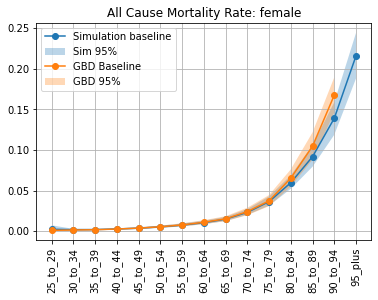

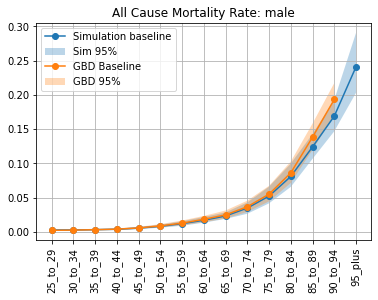

In [80]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_data.loc[(gbd_data.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause Mortality Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for Stroke

In [87]:
gbd_incd = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [88]:
gbd_incd['age'] = gbd_incd.age_group_name.str.replace(' ', '_')
gbd_incd.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       495          523           6          3       1   
1            10       495          523           6          3       2   
2            11       495          523           6          3       1   
3            11       495          523           6          3       2   
4            12       495          523           6          3       1   

   year_id           acause age_group_name       cause_name expected  \
0     2019  cvd_stroke_isch       25 to 29  Ischemic stroke    False   
1     2019  cvd_stroke_isch       25 to 29  Ischemic stroke    False   
2     2019  cvd_stroke_isch       30 to 34  Ischemic stroke    False   
3     2019  cvd_stroke_isch       30 to 34  Ischemic stroke    False   
4     2019  cvd_stroke_isch       35 to 39  Ischemic stroke    False   

  location_name location_type measure_name metric_name     sex       val  \
0       Alabama        admin1    Incidence        Rate    Male  0.000068   
1       Alabama        admin1    Incidence        Rate  Female  0.000115   
2       Alabama        admin1    Incidence        Rate    Male  0.000098   
3       Alabama        admin1    Incidence        Rate  Female  0.000162   
4       Alabama        admin1    Incidence        Rate    Male  0.000145   

      upper     lower       age  
0  0.000147  0.000025  25_to_29  
1  0.000224  0.000050  25_to_29  
2  0.000171  0.000052  30_to_34  
3  0.000265  0.000091  30_to_34  
4  0.000243  0.000077  35_to_39

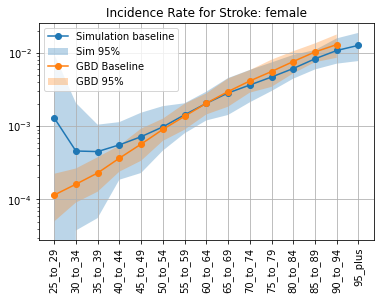

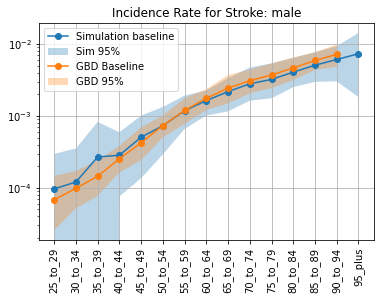

In [89]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd.loc[(gbd_incd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for MI

In [90]:
gbd_incd_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')
gbd_incd_MI['age'] = gbd_incd_MI.age_group_name.str.replace(' ', '_')
gbd_incd_MI.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       493          523           6          3       1   
1            10       493          523           6          3       2   
2            11       493          523           6          3       1   
3            11       493          523           6          3       2   
4            12       493          523           6          3       1   

   year_id   acause age_group_name              cause_name expected  \
0     2019  cvd_ihd       25 to 29  Ischemic heart disease    False   
1     2019  cvd_ihd       25 to 29  Ischemic heart disease    False   
2     2019  cvd_ihd       30 to 34  Ischemic heart disease    False   
3     2019  cvd_ihd       30 to 34  Ischemic heart disease    False   
4     2019  cvd_ihd       35 to 39  Ischemic heart disease    False   

  location_name location_type measure_name metric_name     sex       val  \
0       Alabama        admin1    Incidence        Rate    Male  0.000441   
1       Alabama        admin1    Incidence        Rate  Female  0.000452   
2       Alabama        admin1    Incidence        Rate    Male  0.000621   
3       Alabama        admin1    Incidence        Rate  Female  0.000510   
4       Alabama        admin1    Incidence        Rate    Male  0.000777   

      upper     lower       age  
0  0.000626  0.000274  25_to_29  
1  0.000616  0.000284  25_to_29  
2  0.000818  0.000448  30_to_34  
3  0.000683  0.000345  30_to_34  
4  0.001081  0.000536  35_to_39

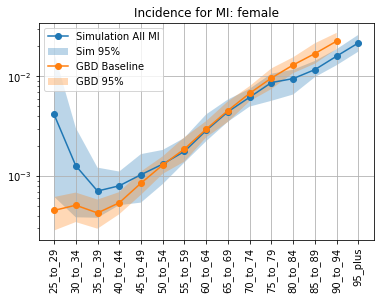

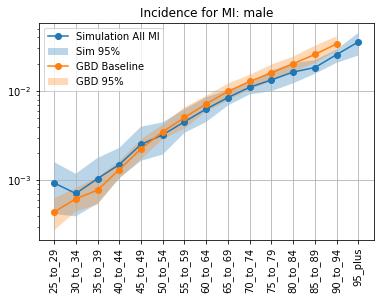

In [91]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence for MI based on all person_time 

In [92]:
tran_rate_MI_GBD = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.loc[(tran_rate_MI_GBD['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = pd.concat([tran_rate_MI_GBD, per_time_group.ptvalue], axis=1)
tran_rate_MI_GBD['rate']= tran_rate_MI_GBD['value'] / tran_rate_MI_GBD['ptvalue']
tran_rate_MI_GBD_summ = (tran_rate_MI_GBD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_MI_GBD_summ.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.004124  0.000396  0.020101
1  25_to_29    male  0.000929  0.000259  0.001825
2  30_to_34  female  0.001265  0.000232  0.003644
3  30_to_34    male  0.000712  0.000237  0.001437
4  35_to_39  female  0.000707  0.000241  0.001499

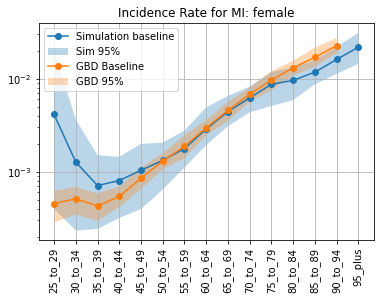

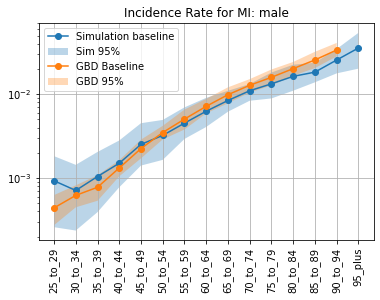

In [93]:
for sex in tran_rate_MI_GBD_summ.sex.unique():
    plt.figure() 
    subdata = tran_rate_MI_GBD_summ.loc[(tran_rate_MI_GBD_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### DALYs from Stroke

In [96]:
gbd_daly = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [97]:
gbd_daly['age'] = gbd_daly.age_group_name.str.replace(' ', '_')
gbd_daly.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       495          523           2          3       1   
1            10       495          523           2          3       2   
2            11       495          523           2          3       1   
3            11       495          523           2          3       2   
4            12       495          523           2          3       1   

   year_id           acause age_group_name       cause_name expected  \
0     2019  cvd_stroke_isch       25 to 29  Ischemic stroke    False   
1     2019  cvd_stroke_isch       25 to 29  Ischemic stroke    False   
2     2019  cvd_stroke_isch       30 to 34  Ischemic stroke    False   
3     2019  cvd_stroke_isch       30 to 34  Ischemic stroke    False   
4     2019  cvd_stroke_isch       35 to 39  Ischemic stroke    False   

  location_name location_type                            measure_name  \
0       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
1       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
2       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
3       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
4       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   

  metric_name     sex       val     upper     lower       age  
0        Rate    Male  0.000573  0.000875  0.000337  25_to_29  
1        Rate  Female  0.000837  0.001272  0.000515  25_to_29  
2        Rate    Male  0.000723  0.001057  0.000457  30_to_34  
3        Rate  Female  0.001110  0.001578  0.000720  30_to_34  
4        Rate    Male  0.000972  0.001417  0.000638  35_to_39

In [98]:
yll_stroke = yll.loc[yll['cause'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke"])].reset_index()
yld_stroke = yld.loc[yld['cause_of_disability'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke"])].reset_index()
yld_stroke = yld_stroke.rename(columns = {'cause_of_disability':'cause'})
yld_stroke

index  Unnamed: 0     sex  year measure  input_draw  scenario  \
0          0           0  female  2023    ylds          29  baseline   
1          1           1  female  2023    ylds          29  baseline   
2          2           2  female  2023    ylds          29  baseline   
3          3           3  female  2023    ylds          29  baseline   
...      ...         ...     ...   ...     ...         ...       ...   
10796  16196       16196    male  2040    ylds         946  baseline   
10797  16197       16197    male  2040    ylds         946  baseline   
10798  16198       16198    male  2040    ylds         946  baseline   
10799  16199       16199    male  2040    ylds         946  baseline   

            age                    cause         yld  
0      25_to_29    acute_ischemic_stroke    0.012643  
1      30_to_34    acute_ischemic_stroke    0.001170  
2      35_to_39    acute_ischemic_stroke    0.000417  
3      40_to_44    acute_ischemic_stroke    0.001347  
...         ...                      ...         ...  
10796  80_to_84  chronic_ischemic_stroke  204.118104  
10797  85_to_89  chronic_ischemic_stroke  137.460226  
10798  90_to_94  chronic_ischemic_stroke   52.581472  
10799   95_plus  chronic_ischemic_stroke   18.053687  

[10800 rows x 10 columns]

In [99]:
daly_stroke = yll_stroke.merge(yld_stroke[['yld','sex','age','year','cause', 'input_draw']], on=['sex','age','year','cause', 'input_draw'])
daly_stroke['daly'] = daly_stroke['yll'] + daly_stroke['yld']
daly_stroke.head()

index  Unnamed: 0     sex  year                  cause measure  input_draw  \
0      0           0  female  2023  acute_ischemic_stroke    ylls          29   
1      1           1  female  2023  acute_ischemic_stroke    ylls          29   
2      2           2  female  2023  acute_ischemic_stroke    ylls          29   
3      3           3  female  2023  acute_ischemic_stroke    ylls          29   
4      4           4  female  2023  acute_ischemic_stroke    ylls          29   

   scenario       age         yll       yld        daly  
0  baseline  25_to_29  120.096394  0.012643  120.109037  
1  baseline  30_to_34   59.156728  0.001170   59.157898  
2  baseline  35_to_39    0.000000  0.000417    0.000417  
3  baseline  40_to_44    0.000000  0.001347    0.001347  
4  baseline  45_to_49   39.817084  0.001731   39.818815

In [100]:
daly_stroke = daly_stroke.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_stroke_rate = pd.concat([daly_stroke, per_time_group.ptvalue], axis=1)
daly_stroke_rate['daly_rate'] = daly_stroke_rate['daly'] / daly_stroke_rate['ptvalue']
daly_stroke_sum_allyear = (daly_stroke_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_stroke_sum_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.007244  0.000492  0.053582
1  25_to_29    male  0.002292  0.000259  0.016576
2  30_to_34  female  0.003366  0.000701  0.013643
3  30_to_34    male  0.001495  0.000388  0.006487
4  35_to_39  female  0.002651  0.000857  0.007759

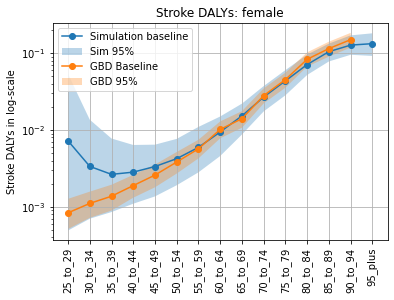

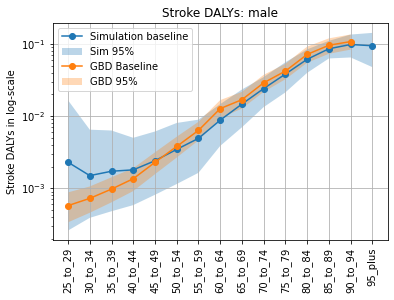

In [101]:
with PdfPages('daly_stroke_artifact_and_sim_model6.pdf') as pdf:
    for sex in daly_stroke_sum_allyear.sex.unique():
        plt.figure() 
        subdata = daly_stroke_sum_allyear.loc[(daly_stroke_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = gbd_daly.loc[(gbd_daly.sex==sex.capitalize())]
        plt.plot(subdata2['age'], subdata2['val'], marker='o')
        plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
        plt.title(f'Stroke DALYs: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 
        plt.ylabel('Stroke DALYs in log-scale') 
        pdf.savefig(bbox_inches='tight')

#### DALYs from Acute MI

In [102]:
gbd_daly_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [103]:
gbd_daly_MI['age'] = gbd_daly_MI.age_group_name.str.replace(' ', '_')
gbd_daly_MI.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       493          523           2          3       1   
1            10       493          523           2          3       2   
2            11       493          523           2          3       1   
3            11       493          523           2          3       2   
4            12       493          523           2          3       1   

   year_id   acause age_group_name              cause_name expected  \
0     2019  cvd_ihd       25 to 29  Ischemic heart disease    False   
1     2019  cvd_ihd       25 to 29  Ischemic heart disease    False   
2     2019  cvd_ihd       30 to 34  Ischemic heart disease    False   
3     2019  cvd_ihd       30 to 34  Ischemic heart disease    False   
4     2019  cvd_ihd       35 to 39  Ischemic heart disease    False   

  location_name location_type                            measure_name  \
0       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
1       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
2       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
3       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
4       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   

  metric_name     sex       val     upper     lower       age  
0        Rate    Male  0.002084  0.002684  0.001595  25_to_29  
1        Rate  Female  0.001076  0.001488  0.000753  25_to_29  
2        Rate    Male  0.005151  0.006505  0.003896  30_to_34  
3        Rate  Female  0.002720  0.003687  0.001977  30_to_34  
4        Rate    Male  0.012157  0.015460  0.009483  35_to_39

In [104]:
yll_MI = yll.loc[yll['cause'].isin(["acute_myocardial_infarction", "post_myocardial_infarction"])].reset_index()
yll_MI = yll_MI.groupby(['age', 'sex', 'year', 'input_draw']).yll.sum().reset_index()
yld_MI = yld.loc[yld['cause_of_disability'].isin(["acute_myocardial_infarction"])].reset_index()
len(yll_MI)

5400

In [105]:
daly_MI = pd.concat([yll_MI, yld_MI.yld], axis=1)
daly_MI['daly'] = daly_MI['yll'] + daly_MI['yld']
daly_MI.head()

age     sex  year  input_draw          yll       yld         daly
0  25_to_29  female  2023          29   490.757207  0.201092   490.958300
1  25_to_29  female  2023         232   443.685931  0.323496   444.009427
2  25_to_29  female  2023         357   431.590648  0.209835   431.800484
3  25_to_29  female  2023         394   181.333317  0.174863   181.508180
4  25_to_29  female  2023         602  1487.685430  0.340983  1488.026413

In [106]:
daly_MI = daly_MI.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_MI_rate = pd.concat([daly_MI, per_time_group.ptvalue], axis=1)
daly_MI_rate['daly_rate'] = daly_MI_rate['daly'] / daly_MI_rate['ptvalue']
daly_MI_rate_allyear = (daly_MI_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_MI_rate_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.076706  0.008794  0.338454
1  25_to_29    male  0.028827  0.007652  0.084611
2  30_to_34  female  0.025937  0.004348  0.058509
3  30_to_34    male  0.016138  0.004135  0.032757
4  35_to_39  female  0.013124  0.002044  0.030263

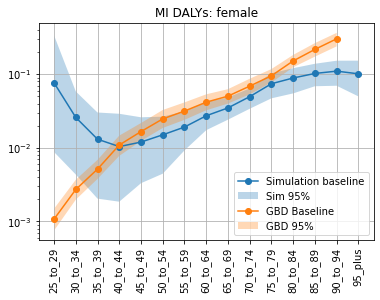

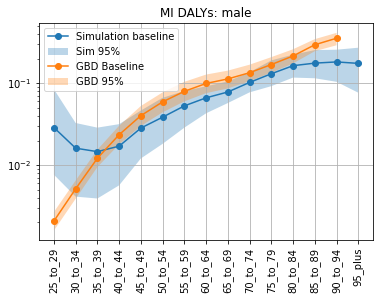

In [107]:
for sex in daly_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = daly_MI_rate_allyear.loc[(daly_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly_MI.loc[(gbd_daly_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'MI DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### LDL-C Testing - Total Exposure by age/year

In [108]:
risk_exp = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
ldl = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl.head()

Unnamed: 0     sex  year                  risk             measure  \
150         150  female  2023  high_ldl_cholesterol  risk_exposure_time   
151         151  female  2023  high_ldl_cholesterol  risk_exposure_time   
152         152  female  2023  high_ldl_cholesterol  risk_exposure_time   
153         153  female  2023  high_ldl_cholesterol  risk_exposure_time   
154         154  female  2023  high_ldl_cholesterol  risk_exposure_time   

     input_draw  scenario       age         value  
150          29  baseline  25_to_29  74867.619205  
151          29  baseline  30_to_34  74498.968965  
152          29  baseline  35_to_39  72722.154520  
153          29  baseline  40_to_44  72299.584866  
154          29  baseline  45_to_49  69323.374133

In [109]:
ldl_summ = (ldl
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
#ldl_summ

In [110]:
%%capture
for sex in ldl_summ.sex.unique():
    for year in ldl_summ.year.unique():
        plt.figure() 
        subdata = ldl_summ.loc[(ldl_summ.sex==sex) & (ldl_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.ylim(0,100000)
        plt.grid()

In [111]:
%%capture
for sex in ldl_summ.sex.unique():
    for age in ldl_summ.age.unique():
        plt.figure() 
        subdata = ldl_summ.loc[(ldl_summ.sex==sex) & (ldl_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

The absolute number is definitely changing over time. Let's see if this is due to changes in population structure or something else. 

### Rates of Exposure by Age/Year

In [112]:
ldl_rate = ldl.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_rate = pd.concat([ldl_rate, per_time_group.ptvalue], axis=1)
ldl_rate['ldl_rate'] = ldl_rate['value'] / ldl_rate['ptvalue']
ldl_rate_summ = (ldl_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  2.772762  2.542984  3.030735
1  25_to_29  female  2024  2.769747  2.541473  3.024597
2  25_to_29  female  2025  2.767112  2.542206  3.019980
3  25_to_29  female  2026  2.767633  2.542798  3.017926
4  25_to_29  female  2027  2.769771  2.545223  3.019157

In [113]:
## Want to think through these. These are now rates - why is it dropping at older age groups? Selection bias 
## (those with high cholestrol don't live as long?) Something else? 

%%capture
for sex in ldl_rate_summ.sex.unique():
    for year in ldl_rate_summ.year.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

UsageError: Line magic function `%%capture` not found.


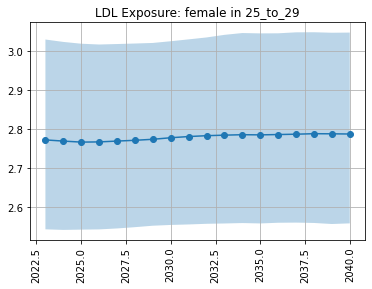

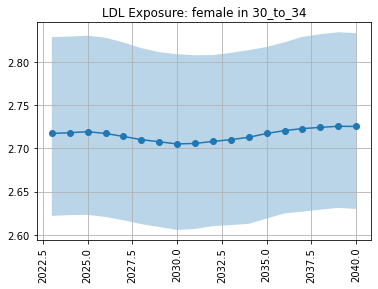

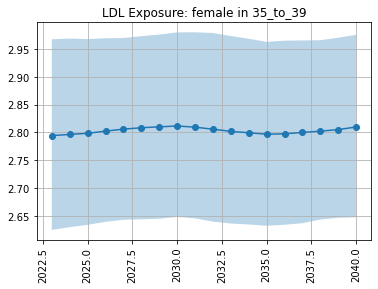

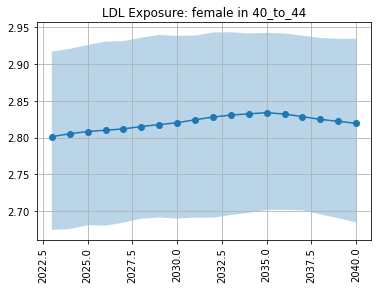

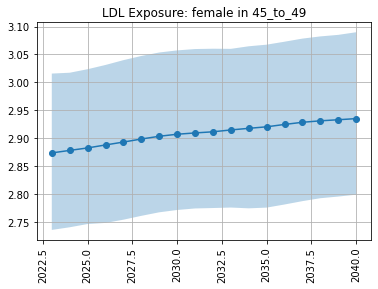

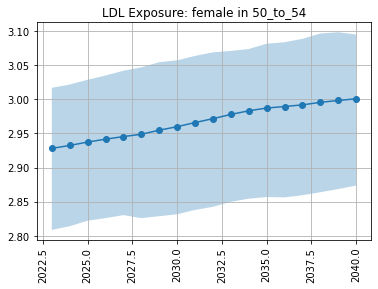

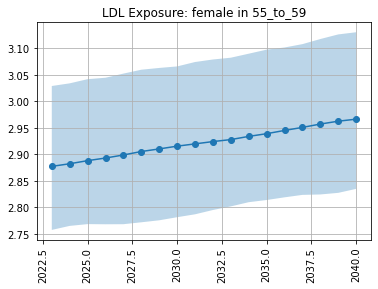

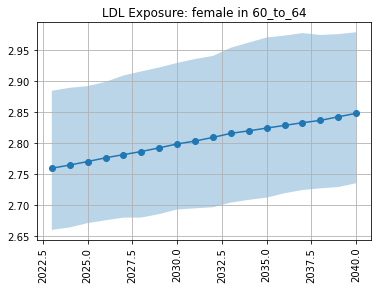

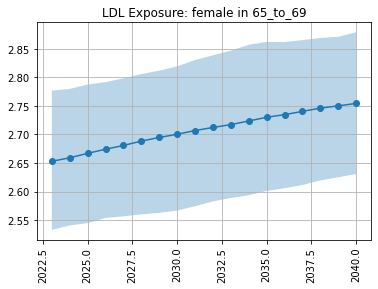

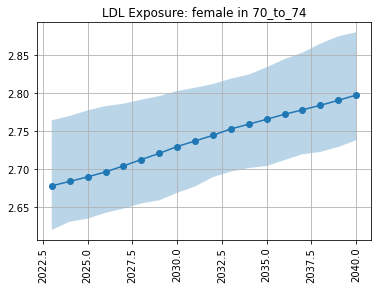

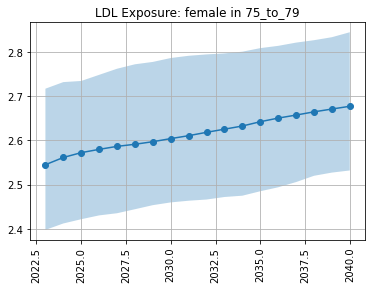

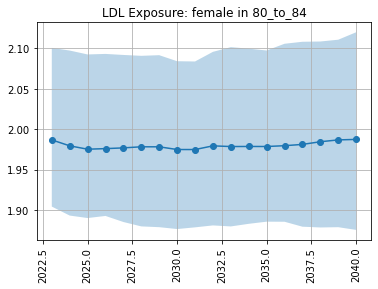

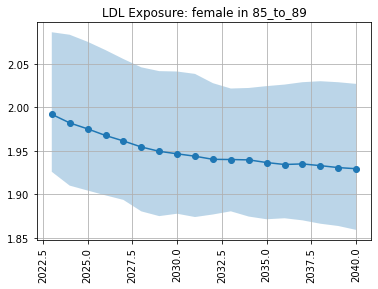

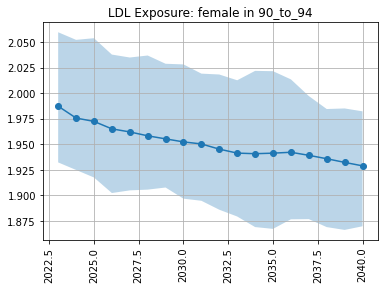

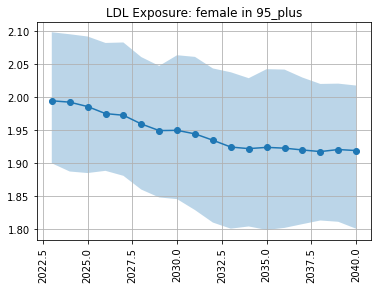

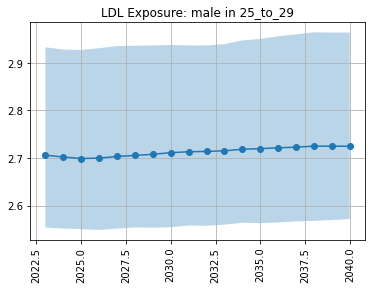

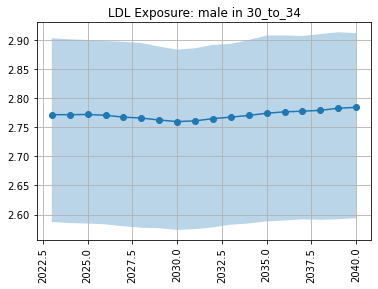

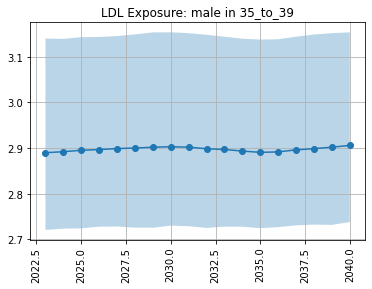

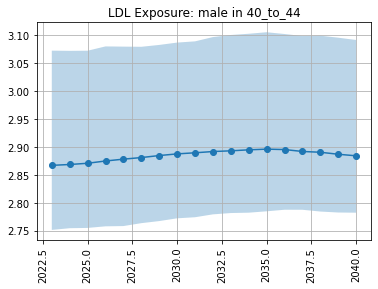

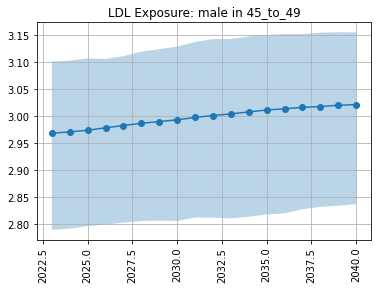

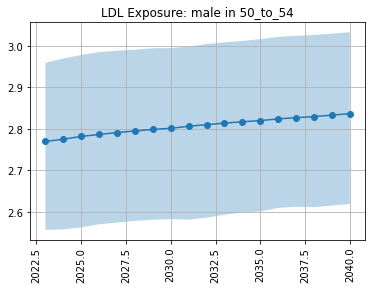

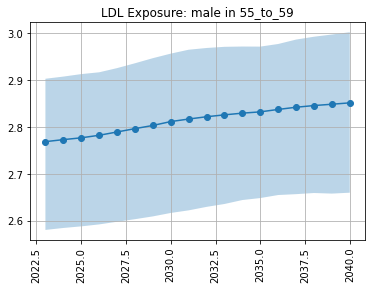

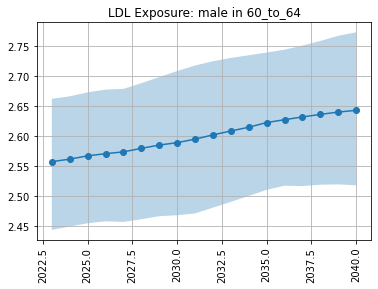

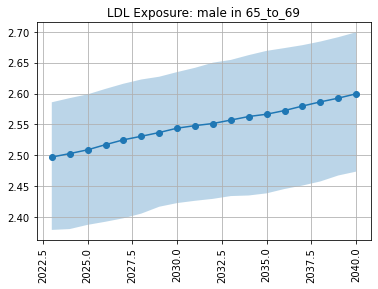

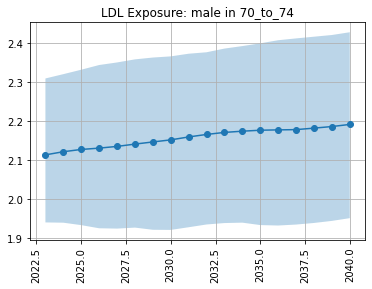

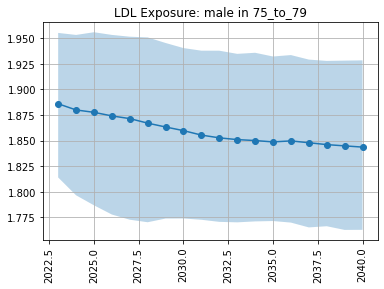

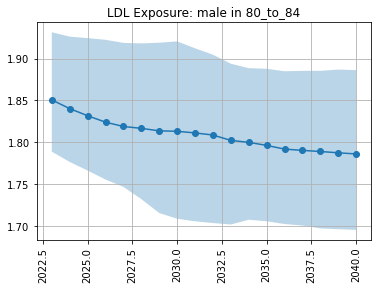

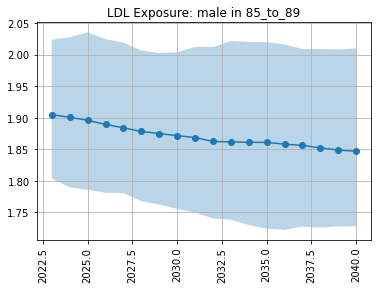

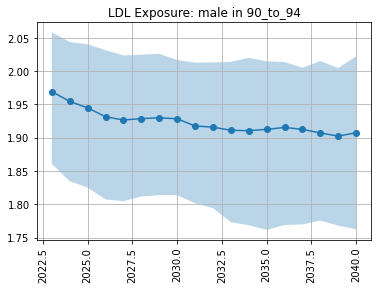

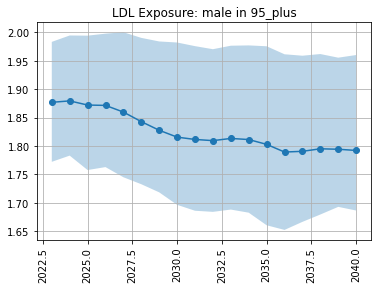

In [114]:
## These look a bit funny - we should discuss. What is causing changes over time across these groups? 
## Why is this not 3? 

#%%capture
for sex in ldl_rate_summ.sex.unique():
    for age in ldl_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

### Within 2023, LDL-C Distribution 

In [115]:
ldl_2023 = ldl.loc[ldl['year']==2023].reset_index()
ldl_2023.head()

index  Unnamed: 0     sex  year                  risk             measure  \
0    150         150  female  2023  high_ldl_cholesterol  risk_exposure_time   
1    151         151  female  2023  high_ldl_cholesterol  risk_exposure_time   
2    152         152  female  2023  high_ldl_cholesterol  risk_exposure_time   
3    153         153  female  2023  high_ldl_cholesterol  risk_exposure_time   
4    154         154  female  2023  high_ldl_cholesterol  risk_exposure_time   

   input_draw  scenario       age         value  
0          29  baseline  25_to_29  74867.619205  
1          29  baseline  30_to_34  74498.968965  
2          29  baseline  35_to_39  72722.154520  
3          29  baseline  40_to_44  72299.584866  
4          29  baseline  45_to_49  69323.374133

### Compare with Artifact 
'risk_factor.high_ldl_cholesterol.distribution' - just says "ensemble"

'risk_factor.high_ldl_cholesterol.exposure'

'risk_factor.high_ldl_cholesterol.exposure_standard_deviation'

'risk_factor.high_ldl_cholesterol.exposure_distribution_weights'- weights of the ensemble dist

'risk_factor.high_ldl_cholesterol.relative_risk'

'risk_factor.high_ldl_cholesterol.population_attributable_fraction'

'risk_factor.high_ldl_cholesterol.tmred' - GBD values, no testing

'risk_factor.high_ldl_cholesterol.relative_risk_scalar' - this is just 1

In [116]:
ldl_exp = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_exp['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_exp.age_start,ldl_exp.age_end)]
ldl_exp.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  female       25.0     30.0        2019      2020  continuous  2.805110   
1  female       30.0     35.0        2019      2020  continuous  2.790157   
2  female       35.0     40.0        2019      2020  continuous  2.855153   
3  female       40.0     45.0        2019      2020  continuous  2.864634   
4  female       45.0     50.0        2019      2020  continuous  2.994765   

       2.5%     97.5% location   measure age_group  
0  2.597516  3.051877  Alabama  exposure  25_to_29  
1  2.588387  2.991761  Alabama  exposure  30_to_34  
2  2.640309  3.069596  Alabama  exposure  35_to_39  
3  2.652549  3.073091  Alabama  exposure  40_to_44  
4  2.785903  3.219201  Alabama  exposure  45_to_49

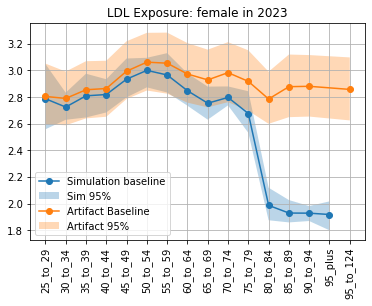

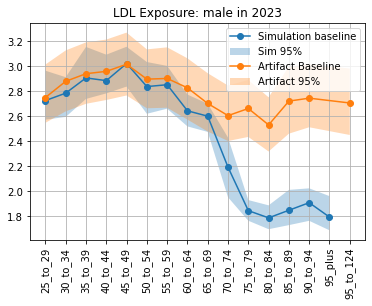

In [117]:
with PdfPages('ldlc_exposure_artifact_and_sim_model6.pdf') as pdf:
    for sex in ldl_rate_summ.sex.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.year==2040)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = ldl_exp.loc[(ldl_exp.sex==sex) & (ldl_exp.year_end==2020)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in 2023') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

### High SBP Risk Factor Testing 

In [118]:
sbp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp.head()

Unnamed: 0     sex  year                          risk  \
300         300  female  2023  high_systolic_blood_pressure   
301         301  female  2023  high_systolic_blood_pressure   
302         302  female  2023  high_systolic_blood_pressure   
303         303  female  2023  high_systolic_blood_pressure   
304         304  female  2023  high_systolic_blood_pressure   

                measure  input_draw  scenario       age         value  
300  risk_exposure_time          29  baseline  25_to_29  3.204044e+06  
301  risk_exposure_time          29  baseline  30_to_34  3.360364e+06  
302  risk_exposure_time          29  baseline  35_to_39  2.860912e+06  
303  risk_exposure_time          29  baseline  40_to_44  3.124054e+06  
304  risk_exposure_time          29  baseline  45_to_49  2.912528e+06

In [119]:
sbp_summ = (sbp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
#sbp_summ

In [120]:
%%capture
for sex in sbp_summ.sex.unique():
    for year in sbp_summ.year.unique():
        plt.figure() 
        subdata = sbp_summ.loc[(sbp_summ.sex==sex) & (sbp_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [121]:
#Some interesting patterns going on here - since it is not a rate I am not overly concerned but might be worth a look
%%capture
for sex in sbp_summ.sex.unique():
    for age in sbp_summ.age.unique():
        plt.figure() 
        subdata = sbp_summ.loc[(sbp_summ.sex==sex) & (sbp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

UsageError: Line magic function `%%capture` not found.


In [122]:
sbp_rate = sbp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_rate = pd.concat([sbp_rate, per_time_group.ptvalue], axis=1)
sbp_rate['ldl_rate'] = sbp_rate['value'] / sbp_rate['ptvalue']
sbp_rate_summ = (sbp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_rate_summ.head()

age     sex  year        mean        2.5%       97.5%
0  25_to_29  female  2023  114.393756  106.575193  120.026903
1  25_to_29  female  2024  114.357453  106.577842  119.991418
2  25_to_29  female  2025  114.334063  106.551837  119.954059
3  25_to_29  female  2026  114.323748  106.585771  119.924035
4  25_to_29  female  2027  114.331326  106.607664  119.939499

In [123]:
%%capture
for sex in sbp_rate_summ.sex.unique():
    for year in sbp_rate_summ.year.unique():
        plt.figure() 
        subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

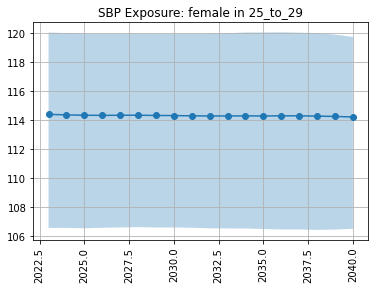

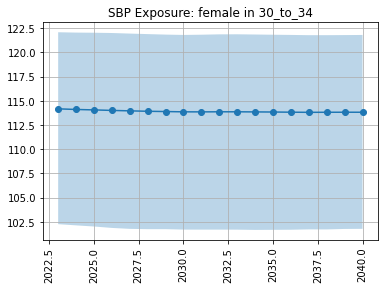

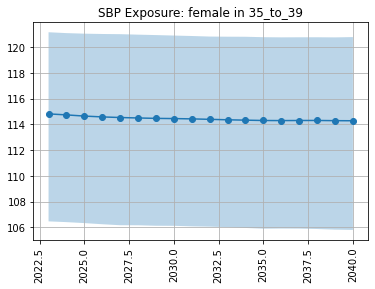

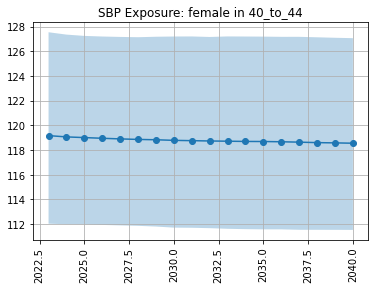

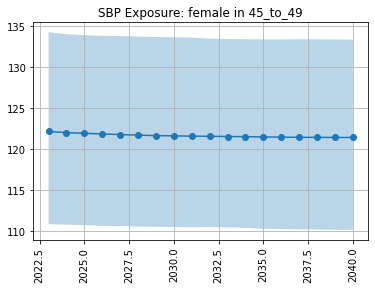

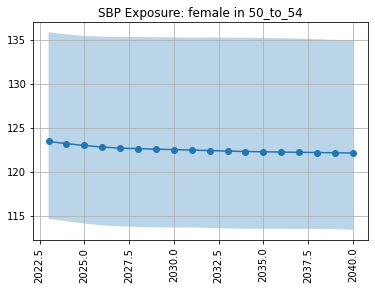

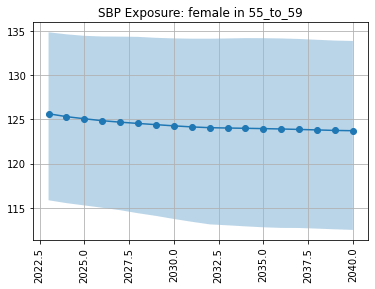

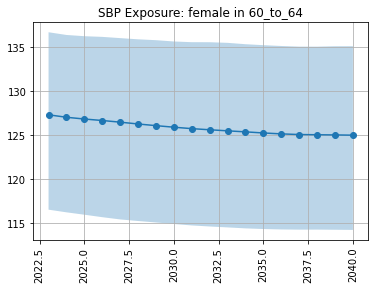

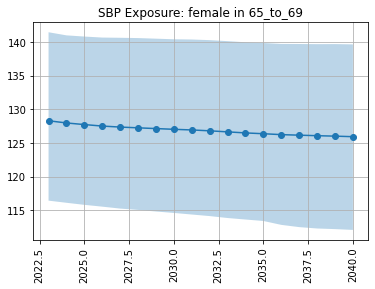

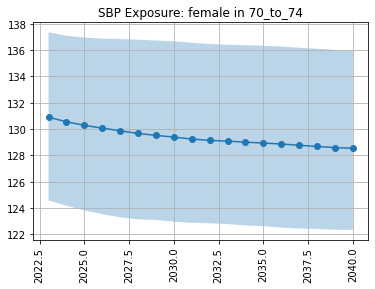

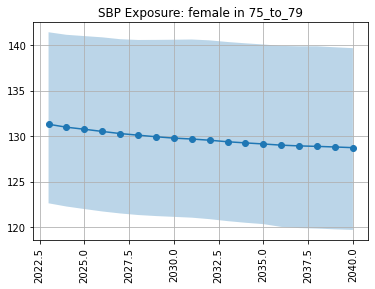

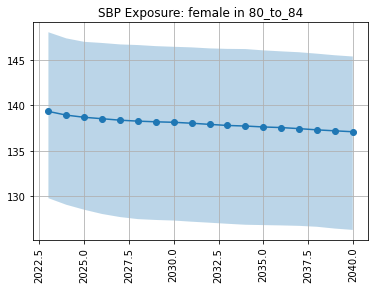

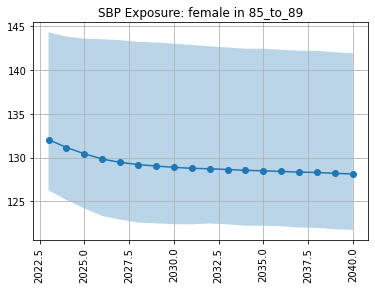

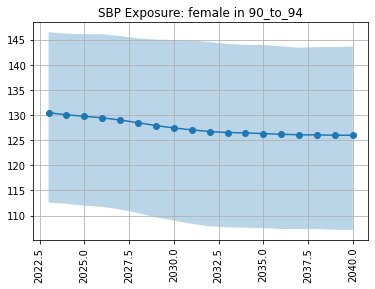

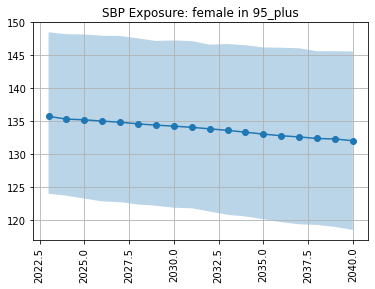

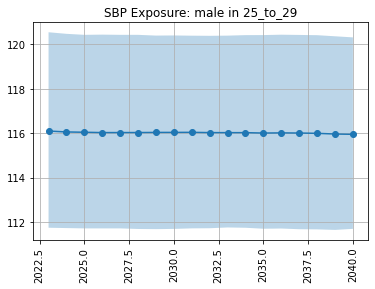

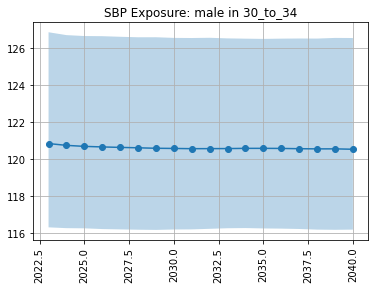

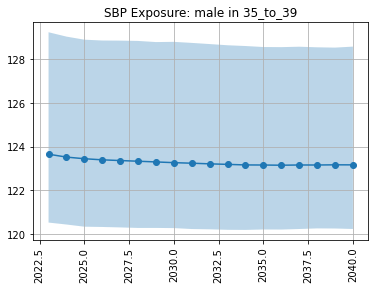

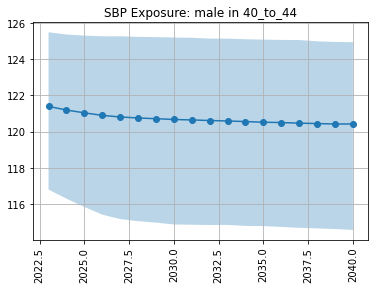

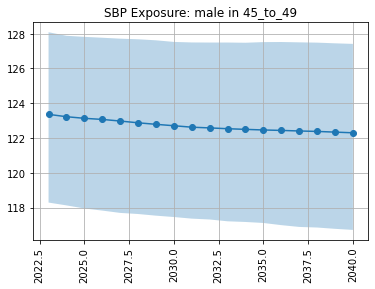

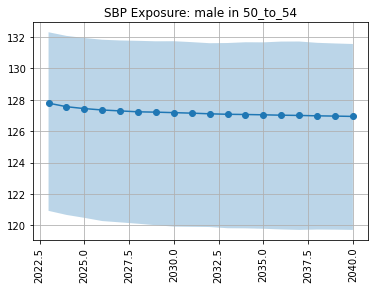

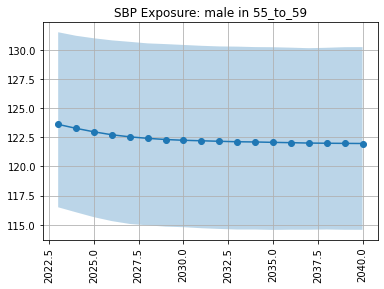

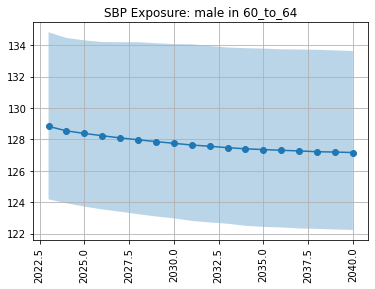

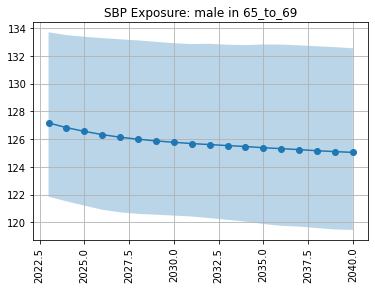

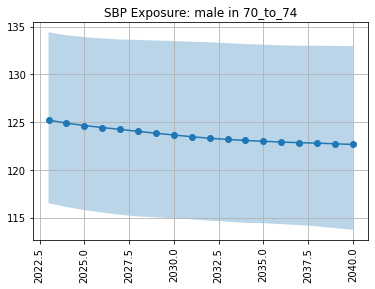

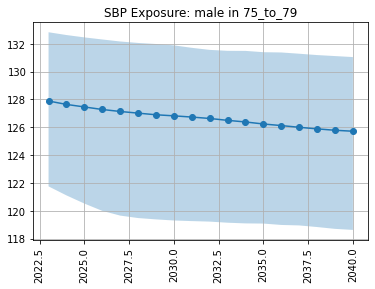

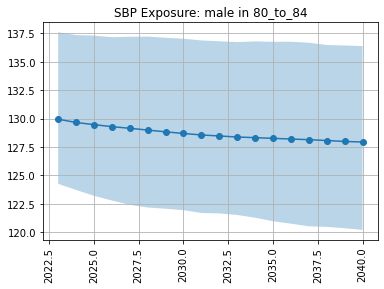

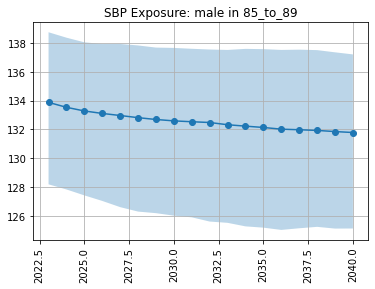

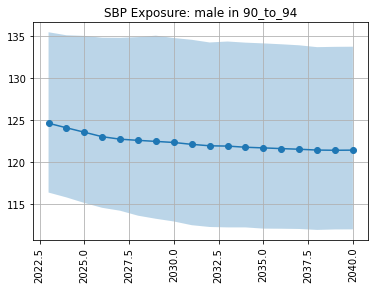

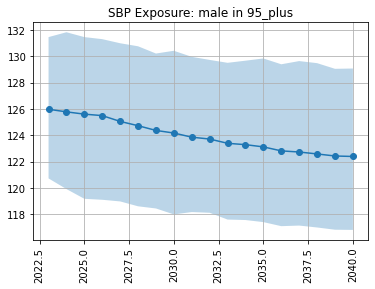

In [124]:
#%%capture
for sex in sbp_rate_summ.sex.unique():
    for age in sbp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

Overall this is looking better than expected! There is a slight but definitive downward slope across ages, but not large. This is seen in incidence and prevalence of different causes. 

In [125]:
sbp_exp = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_exp['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_exp.age_start,sbp_exp.age_end)]
sbp_exp.head()

sex  age_start  age_end  year_start  year_end   parameter        mean  \
0  female       25.0     30.0        2019      2020  continuous  114.500732   
1  female       30.0     35.0        2019      2020  continuous  113.207856   
2  female       35.0     40.0        2019      2020  continuous  115.716469   
3  female       40.0     45.0        2019      2020  continuous  118.712085   
4  female       45.0     50.0        2019      2020  continuous  123.960399   

         2.5%       97.5% location   measure age_group  
0  101.716393  127.389503  Alabama  exposure  25_to_29  
1  100.753767  126.385370  Alabama  exposure  30_to_34  
2  103.617384  128.913762  Alabama  exposure  35_to_39  
3  105.661678  133.771730  Alabama  exposure  40_to_44  
4  110.054265  139.549595  Alabama  exposure  45_to_49

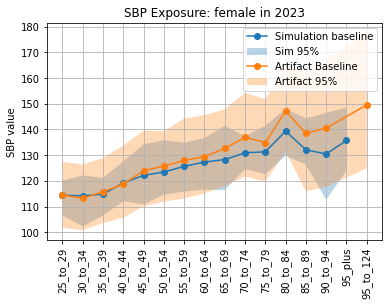

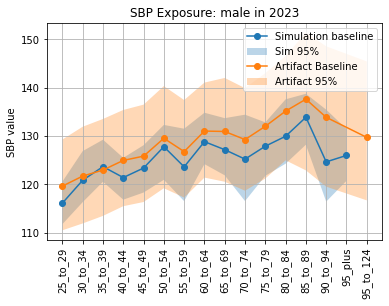

In [126]:
with PdfPages('sbp_exposure_artifact_and_sim_model6.pdf') as pdf:
    for sex in sbp_rate_summ.sex.unique():
        plt.figure() 
        subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.year==2023)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = sbp_exp.loc[(sbp_exp.sex==sex) & (sbp_exp.year_end==2020)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in 2023') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        plt.ylabel('SBP value')
        pdf.savefig(bbox_inches='tight')

Similar to the above - we see setting this to 2040 that the simulation exposure is significantly reduced from the artifact. 

Interestingly though, setting it to 2023 does not show a stunning different result. That indicates that the slope isn't bad, but something about initialization? 

## Healthcare Appointments

### Background Visits Match with Artfifact

In [127]:
visits = pd.read_csv(sim_results_dir + 'healthcare_visits.csv')
visits.head()

Unnamed: 0     sex  year            measure  input_draw  scenario  \
0           0  female  2023  healthcare_visits          29  baseline   
1           1  female  2023  healthcare_visits          29  baseline   
2           2  female  2023  healthcare_visits          29  baseline   
3           3  female  2023  healthcare_visits          29  baseline   
4           4  female  2023  healthcare_visits          29  baseline   

        age  visit_type  value  
0  25_to_29  background  66710  
1  30_to_34  background  75372  
2  35_to_39  background  85327  
3  40_to_44  background  64285  
4  45_to_49  background  61805

In [128]:
screening_art = load_artifact_data('healthcare_entity', 'outpatient_visits', 'outpatient_envelope')
screening_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(screening_art.age_start,screening_art.age_end)]
screening_art.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  2.639679  1.660388   
1  female       30.0     35.0        2019      2020  2.903855  1.787758   
2  female       35.0     40.0        2019      2020  3.165061  1.993188   
3  female       40.0     45.0        2019      2020  3.527738  2.254962   
4  female       45.0     50.0        2019      2020  3.905085  2.416913   

      97.5% location              measure age_group  
0  4.076512  Alabama  outpatient_envelope  25_to_29  
1  4.386895  Alabama  outpatient_envelope  30_to_34  
2  4.815238  Alabama  outpatient_envelope  35_to_39  
3  5.141563  Alabama  outpatient_envelope  40_to_44  
4  5.692975  Alabama  outpatient_envelope  45_to_49

In [129]:
screen = visits.loc[visits['visit_type']=='background'].reset_index()
screen_rate = screen.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
screen_rate['screen_rate'] = screen_rate['value'] / screen_rate['ptvalue']
screen_rate_summ = (screen_rate
                .groupby(['age', 'sex', 'year'])
                .screen_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
screen_rate_summ

age     sex  year      mean      2.5%     97.5%
0    25_to_29  female  2023  2.193308  1.678931  2.873914
1    25_to_29  female  2024  2.192993  1.679208  2.869445
2    25_to_29  female  2025  2.194275  1.680070  2.861488
3    25_to_29  female  2026  2.198091  1.700213  2.872299
..        ...     ...   ...       ...       ...       ...
536   95_plus    male  2037  4.879587  3.766967  6.276267
537   95_plus    male  2038  4.908842  3.724728  6.324708
538   95_plus    male  2039  4.910760  3.800252  6.342265
539   95_plus    male  2040  4.955537  3.743023  6.361092

[540 rows x 6 columns]

In [130]:
%%capture
for sex in screen_rate_summ.sex.unique():
    for year in screen_rate_summ.year.unique():
        plt.figure() 
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Screening Visits: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [131]:
%%capture
for sex in screen_rate_summ.sex.unique():
    for age in screen_rate_summ.age.unique():
        plt.figure() 
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Screening Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

Since the year over year is looking better than I expected, I think sum over years and compare with the artifact

In [132]:
screen_rate_summ_allyear = (screen_rate
                .groupby(['age', 'sex'])
                .screen_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
screen_rate_summ_allyear

age     sex      mean      2.5%     97.5%
0   25_to_29  female  2.203325  1.642203  2.970671
1   25_to_29    male  1.181025  0.918186  1.481413
2   30_to_34  female  2.481019  1.965780  2.909938
3   30_to_34    male  1.376172  1.041178  1.579594
..       ...     ...       ...       ...       ...
26  90_to_94  female  3.560007  3.117920  4.582121
27  90_to_94    male  3.639378  3.095661  5.019933
28   95_plus  female  4.941155  3.607253  6.608984
29   95_plus    male  4.926462  3.689847  6.700683

[30 rows x 5 columns]

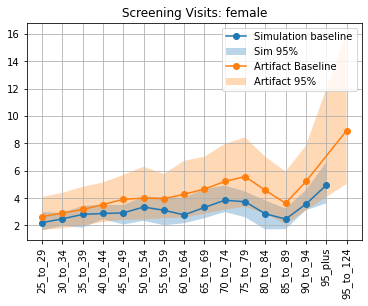

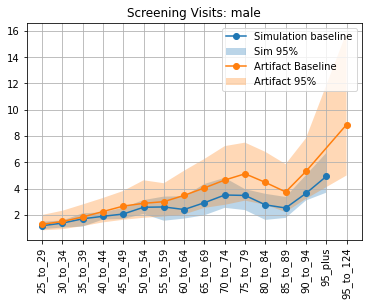

In [133]:
for sex in screen_rate_summ_allyear.sex.unique():
    plt.figure() 
    subdata = screen_rate_summ_allyear.loc[(screen_rate_summ_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = screening_art.loc[(screening_art.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Screening Visits: {sex}') 
    plt.xticks(rotation=90) 
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%'])     
    plt.grid()

In [134]:
screen_rate_2023 = screen_rate_summ.loc[screen_rate_summ['year']==2023].reset_index()

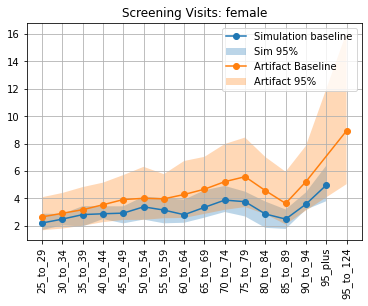

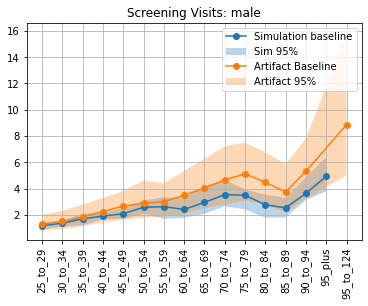

In [135]:
for sex in screen_rate_2023.sex.unique():
    plt.figure() 
    subdata = screen_rate_2023.loc[(screen_rate_2023.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = screening_art.loc[(screening_art.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Screening Visits: {sex}') 
    plt.xticks(rotation=90) 
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%'])     
    plt.grid()

This is chronically low. My guess is because follow-up appointments take priority and so there is less opportunity for a screening that the math would indicate. 

### Emergency Visits Match Incidence

In [136]:
emg = visits.loc[visits['visit_type']=='emergency'].reset_index()
emg_rate = emg.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
emg_rate['emg_rate'] = emg_rate['value'] / emg_rate['ptvalue']
emg_rate_summ = (emg_rate
                .groupby(['age', 'sex', 'year'])
                .emg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
emg_rate_summ

age     sex  year      mean      2.5%     97.5%
0    25_to_29  female  2023  0.009072  0.000821  0.037269
1    25_to_29  female  2024  0.008682  0.000832  0.035509
2    25_to_29  female  2025  0.008335  0.000986  0.033474
3    25_to_29  female  2026  0.007897  0.000700  0.035083
..        ...     ...   ...       ...       ...       ...
536   95_plus    male  2037  0.042521  0.030553  0.052394
537   95_plus    male  2038  0.044362  0.030101  0.061987
538   95_plus    male  2039  0.039793  0.032003  0.050585
539   95_plus    male  2040  0.042599  0.032127  0.059069

[540 rows x 6 columns]

In [137]:
inc_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
inc_rate = inc_rate.loc[(inc_rate['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke']))].reset_index()
inc_rate = inc_rate.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
inc_rate = pd.concat([inc_rate, per_time_group.ptvalue], axis=1)
inc_rate['rate']= inc_rate['value'] / inc_rate['ptvalue']
inc_rate_summ = (inc_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

inc_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.009174  0.000821  0.037703
1  25_to_29  female  2024  0.008840  0.000832  0.036255
2  25_to_29  female  2025  0.008492  0.000986  0.034154
3  25_to_29  female  2026  0.008047  0.000700  0.035924
4  25_to_29  female  2027  0.007240  0.000667  0.033374

In [138]:
%%capture
for sex in emg_rate_summ.sex.unique():
    for year in emg_rate_summ.year.unique():
        plt.figure() 
        subdata = emg_rate_summ.loc[(emg_rate_summ.sex==sex) & (emg_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = inc_rate_summ.loc[(inc_rate_summ.sex==sex) & (inc_rate_summ.year==year)]
        plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Emergency Visits Compared with Incidence of MI and Stroke: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.legend(['Emergency Visits baseline', 'Sim 95%', 'Incidence of MI and Stroke', '95%'])
        plt.grid()

### Look at Follow-ups 

In [139]:
followup = visits.loc[visits['visit_type']=='scheduled'].reset_index()
followup_rate = followup.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
followup_rate['followup_rate'] = followup_rate['value'] / followup_rate['ptvalue']
followup_rate_summ = (followup_rate
                .groupby(['age', 'sex', 'year'])
                .followup_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
followup_rate_summ

age     sex  year      mean      2.5%     97.5%
0    25_to_29  female  2023  0.310130  0.173007  0.469152
1    25_to_29  female  2024  0.301277  0.163118  0.468477
2    25_to_29  female  2025  0.289860  0.148643  0.465989
3    25_to_29  female  2026  0.282029  0.141199  0.452861
..        ...     ...   ...       ...       ...       ...
536   95_plus    male  2037  2.050597  1.942472  2.125365
537   95_plus    male  2038  2.045091  1.939065  2.142220
538   95_plus    male  2039  2.041080  1.940754  2.115925
539   95_plus    male  2040  2.034263  1.907510  2.125433

[540 rows x 6 columns]

In [140]:
%%capture
for sex in followup_rate_summ.sex.unique():
    for year in followup_rate_summ.year.unique():
        plt.figure() 
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Follow-up Visits: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [141]:
%%capture
for sex in followup_rate_summ.sex.unique():
    for age in followup_rate_summ.age.unique():
        plt.figure() 
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Follow-up Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

Follow-up visits decrease over time for younger groups. Why is this? Lost to follow-up by missed appointments I suppose? 

## SBP Medications

In [142]:
meds = pd.read_csv(sim_results_dir + 'sbp_medication_person_time.csv')
meds.head()

Unnamed: 0     sex  year                     measure  input_draw  scenario  \
0           0  female  2023  sbp_medication_person_time          29  baseline   
1           1  female  2023  sbp_medication_person_time          29  baseline   
2           2  female  2023  sbp_medication_person_time          29  baseline   
3           3  female  2023  sbp_medication_person_time          29  baseline   
4           4  female  2023  sbp_medication_person_time          29  baseline   

        age    medication_adherence sbp_medication         value  
0  25_to_29    primary_non_adherent   no_treatment   3895.315537  
1  25_to_29  secondary_non_adherent   no_treatment   2397.382615  
2  25_to_29                adherent   no_treatment  17234.737851  
3  30_to_34    primary_non_adherent   no_treatment   2747.258042  
4  30_to_34  secondary_non_adherent   no_treatment   1804.878850

In [145]:
meds_adherent = meds.loc[meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['age', 'sex', 'year', 'sbp_medication'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

age     sex  year                 sbp_medication      mean  \
0     25_to_29  female  2023                   no_treatment  0.638625   
1     25_to_29  female  2023    one_drug_half_dose_efficacy  0.074378   
2     25_to_29  female  2023     one_drug_std_dose_efficacy  0.001204   
3     25_to_29  female  2023  three_drug_half_dose_efficacy  0.000372   
...        ...     ...   ...                            ...       ...   
3776   95_plus    male  2040  three_drug_half_dose_efficacy  0.078774   
3777   95_plus    male  2040   three_drug_std_dose_efficacy  0.195641   
3778   95_plus    male  2040    two_drug_half_dose_efficacy  0.130296   
3779   95_plus    male  2040     two_drug_std_dose_efficacy  0.072429   

          2.5%     97.5%  
0     0.581434  0.688590  
1     0.032432  0.123566  
2     0.000156  0.002347  
3     0.000047  0.000719  
...        ...       ...  
3776  0.052239  0.097765  
3777  0.086663  0.287442  
3778  0.107280  0.148605  
3779  0.043867  0.089551  

[3780 rows x 7 columns]

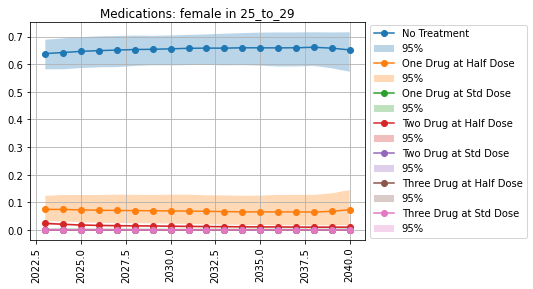

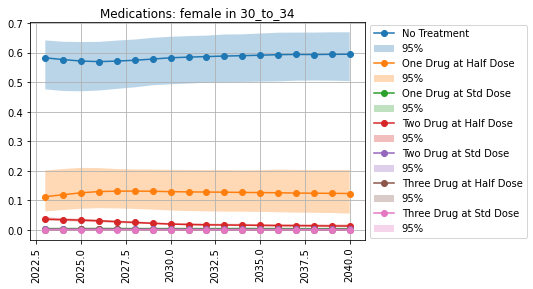

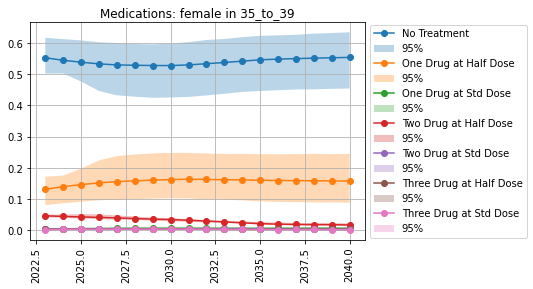

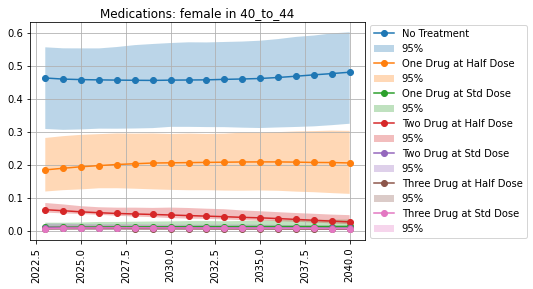

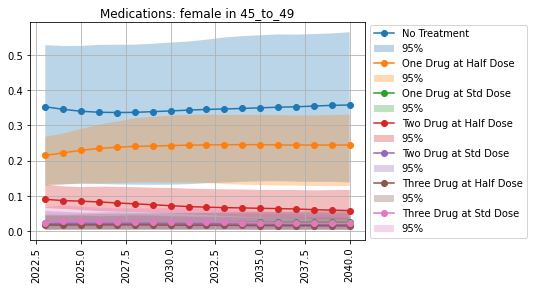

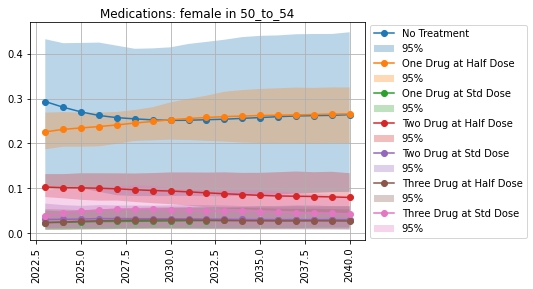

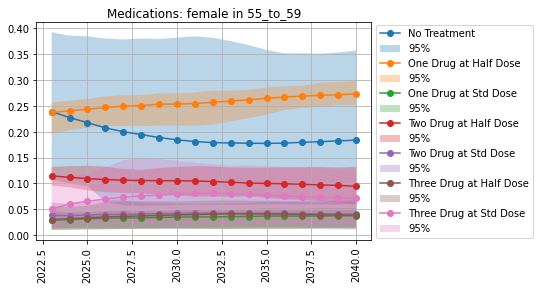

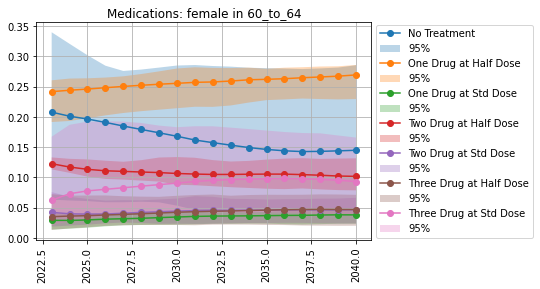

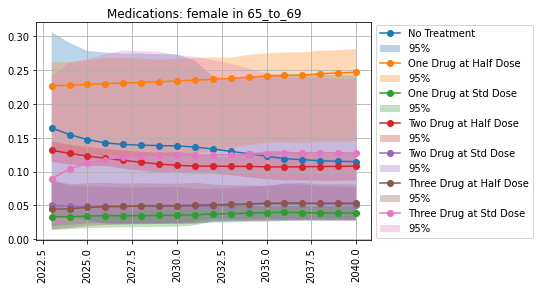

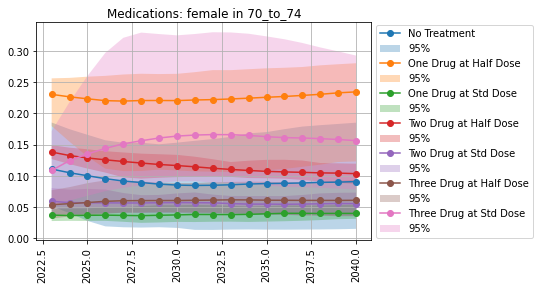

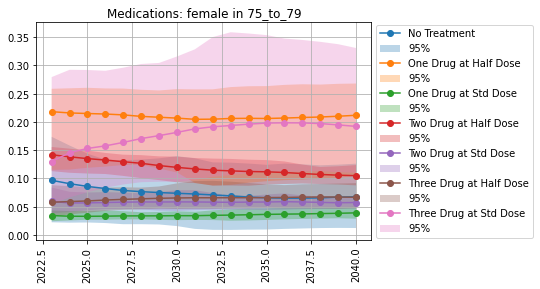

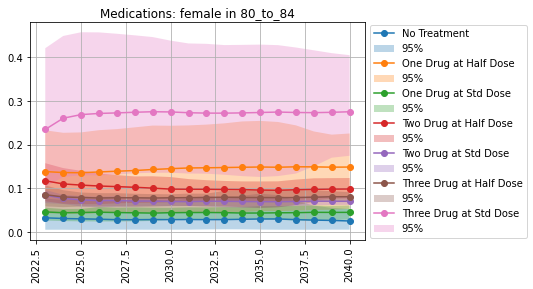

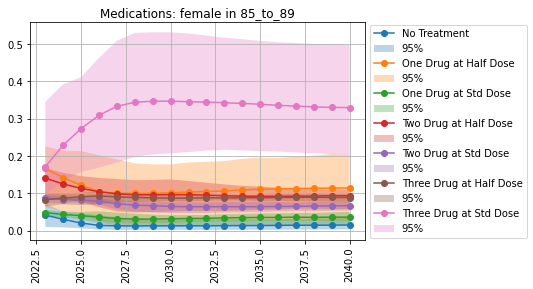

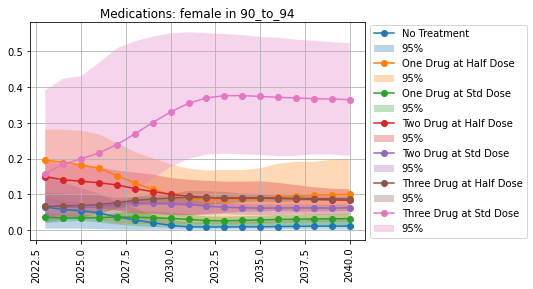

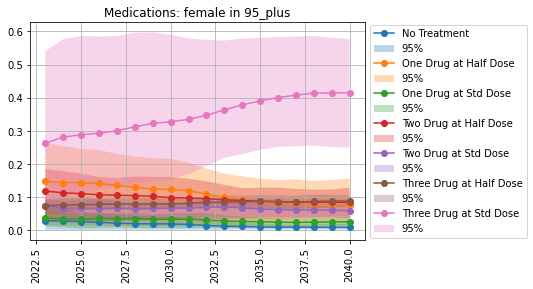

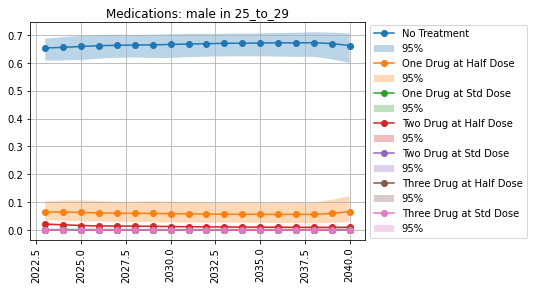

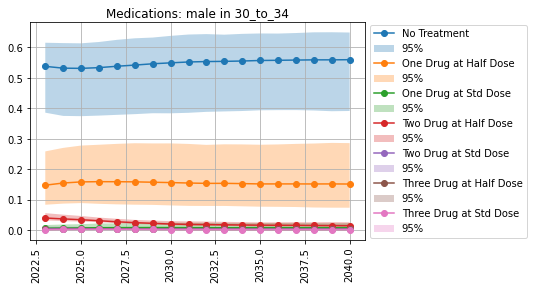

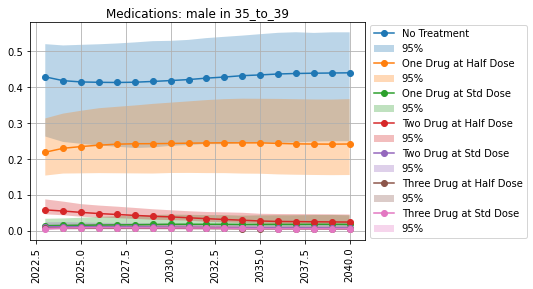

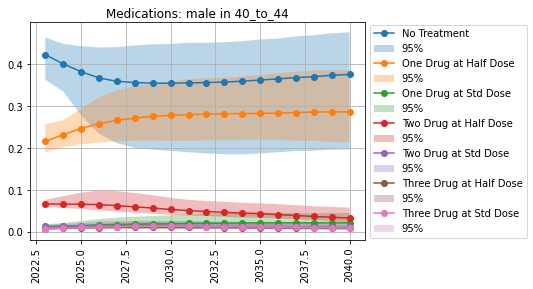

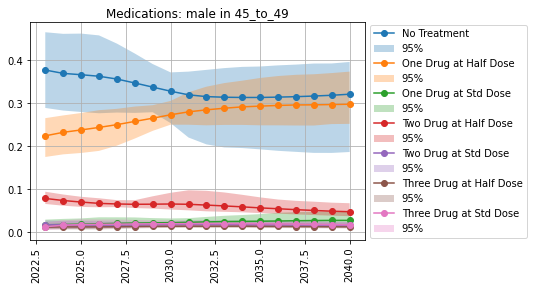

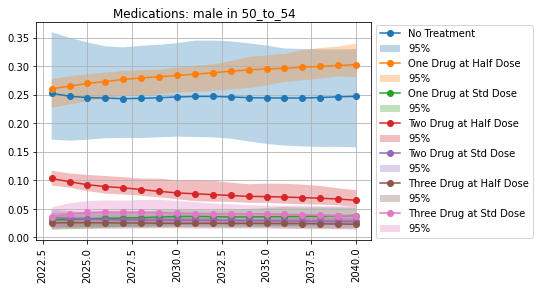

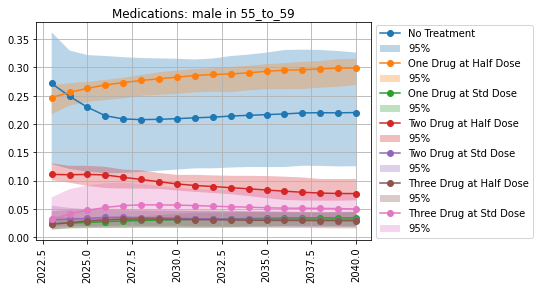

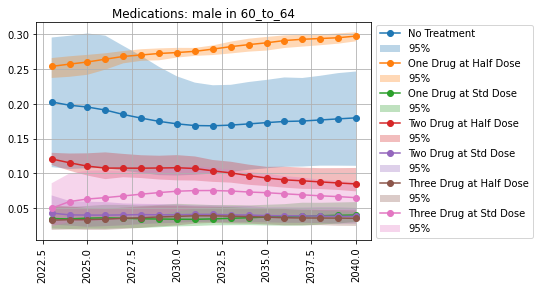

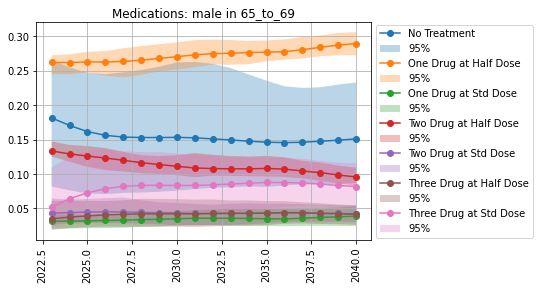

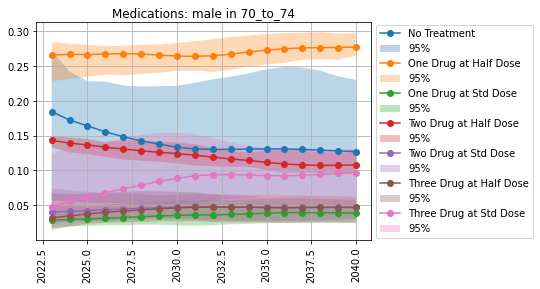

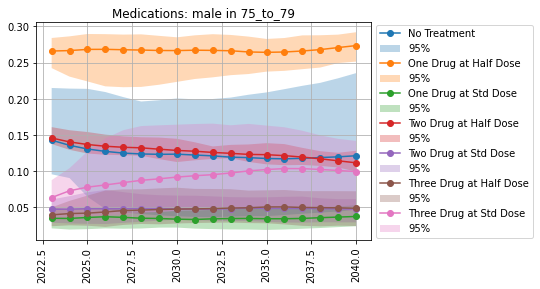

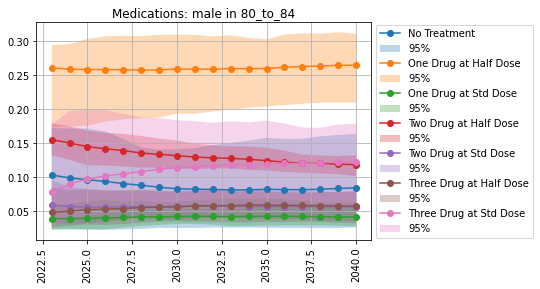

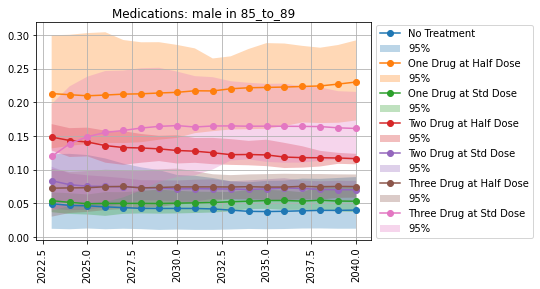

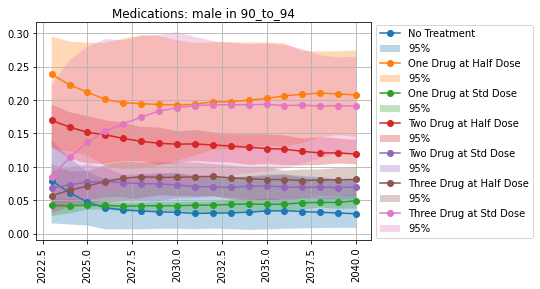

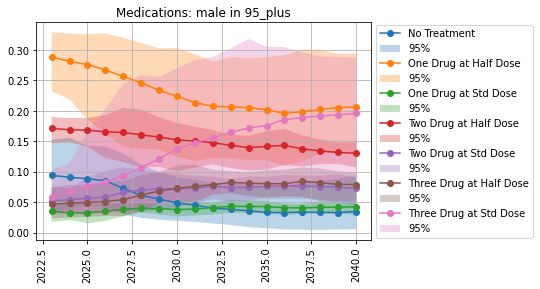

In [149]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        plt.fill_between(no_trt['year'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='one_drug_half_dose_efficacy')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        plt.fill_between(one_half['year'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='one_drug_std_dose_efficacy')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        plt.fill_between(one_std['year'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='two_drug_half_dose_efficacy')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        plt.fill_between(two_half['year'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='two_drug_std_dose_efficacy')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        plt.fill_between(two_std['year'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='three_drug_half_dose_efficacy')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        plt.fill_between(three_half['year'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
        three_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='three_drug_std_dose_efficacy')]
        plt.plot(three_std['year'], three_std['mean'], marker='o')
        plt.fill_between(three_std['year'], three_std['2.5%'], three_std['97.5%'], alpha=.3)
        plt.title(f'Medications: {sex} in {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', '95%', 'One Drug at Half Dose', '95%', 'One Drug at Std Dose','95%','Two Drug at Half Dose', '95%','Two Drug at Std Dose', '95%','Three Drug at Half Dose', '95%','Three Drug at Std Dose', '95%'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()

In [148]:
%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for year in meds_adherent_rate_summ.year.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.sbp_medication=='no_treatment')]
        plt.plot(no_trt['age'], no_trt['mean'], marker='o')
        plt.fill_between(no_trt['age'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.sbp_medication=='one_drug_half_dose_efficacy')]
        plt.plot(one_half['age'], one_half['mean'], marker='o')
        plt.fill_between(one_half['age'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.sbp_medication=='one_drug_std_dose_efficacy')]
        plt.plot(one_std['age'], one_std['mean'], marker='o')
        plt.fill_between(one_std['age'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.sbp_medication=='two_drug_half_dose_efficacy')]
        plt.plot(two_half['age'], two_half['mean'], marker='o')
        plt.fill_between(two_half['age'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.sbp_medication=='two_drug_std_dose_efficacy')]
        plt.plot(two_std['age'], two_std['mean'], marker='o')
        plt.fill_between(two_std['age'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.sbp_medication=='three_drug_half_dose_efficacy')]
        plt.plot(three_half['age'], three_half['mean'], marker='o')
        plt.fill_between(three_half['age'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
        three_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.sbp_medication=='three_drug_std_dose_efficacy')]
        plt.plot(three_std['age'], three_std['mean'], marker='o')
        plt.fill_between(three_std['age'], three_std['2.5%'], three_std['97.5%'], alpha=.3)
        plt.title(f'Medications: {sex} in {year}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', '95%', 'One Drug at Half Dose', '95%', 'One Drug at Std Dose','95%','Two Drug at Half Dose', '95%','Two Drug at Std Dose', '95%','Three Drug at Half Dose', '95%','Three Drug at Std Dose', '95%'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()

## LDL-C Medications

In [151]:
ldl_meds = pd.read_csv(sim_results_dir + 'ldlc_medication_person_time.csv')
ldl_meds.head()

Unnamed: 0     sex  year                      measure  input_draw  \
0           0  female  2023  ldlc_medication_person_time          29   
1           1  female  2023  ldlc_medication_person_time          29   
2           2  female  2023  ldlc_medication_person_time          29   
3           3  female  2023  ldlc_medication_person_time          29   
4           4  female  2023  ldlc_medication_person_time          29   

   scenario       age    medication_adherence ldlc_medication       value  
0  baseline  25_to_29    primary_non_adherent  high_intensity    0.000000  
1  baseline  25_to_29  secondary_non_adherent  high_intensity    0.000000  
2  baseline  25_to_29                adherent  high_intensity  163.055441  
3  baseline  30_to_34    primary_non_adherent  high_intensity    0.000000  
4  baseline  30_to_34  secondary_non_adherent  high_intensity    0.000000

In [152]:
meds_adherent = ldl_meds.loc[ldl_meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['age', 'sex', 'year', 'ldlc_medication'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

age     sex  year   ldlc_medication      mean      2.5%     97.5%
0     25_to_29  female  2023    high_intensity  0.007944  0.005509  0.010466
1     25_to_29  female  2023     high_with_eze  0.015917  0.010777  0.020757
2     25_to_29  female  2023     low_intensity  0.000240  0.000079  0.000401
3     25_to_29  female  2023  low_med_with_eze  0.005646  0.004281  0.006817
...        ...     ...   ...               ...       ...       ...       ...
3236   95_plus    male  2040     low_intensity  0.006397  0.003256  0.009851
3237   95_plus    male  2040  low_med_with_eze  0.109137  0.080689  0.129519
3238   95_plus    male  2040  medium_intensity  0.111675  0.069637  0.158503
3239   95_plus    male  2040      no_treatment  0.014040  0.004992  0.026698

[3240 rows x 7 columns]

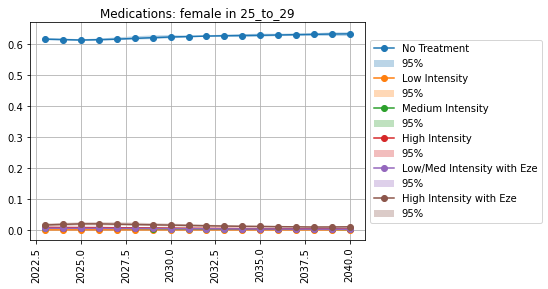

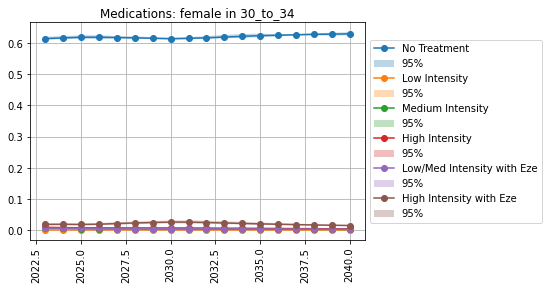

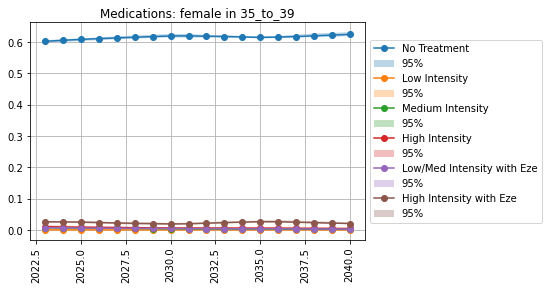

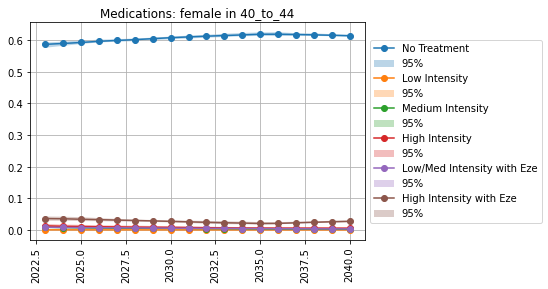

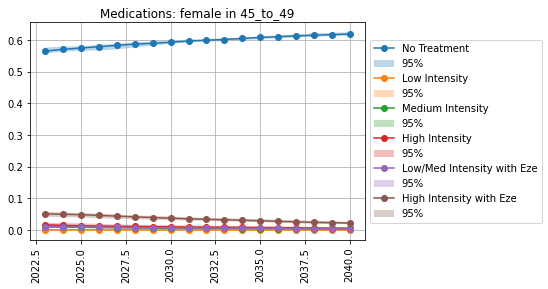

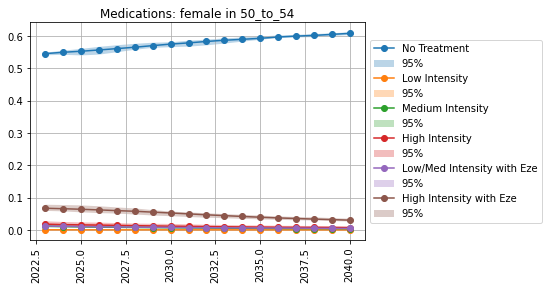

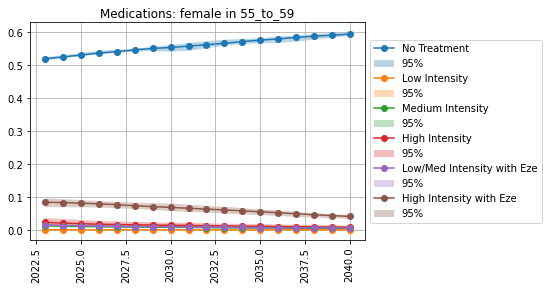

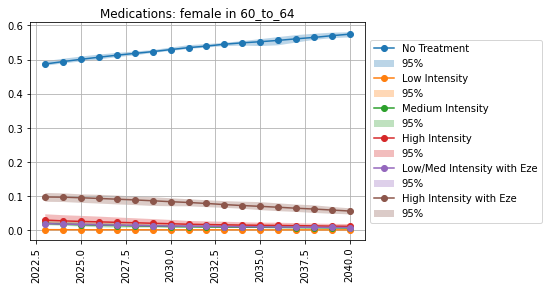

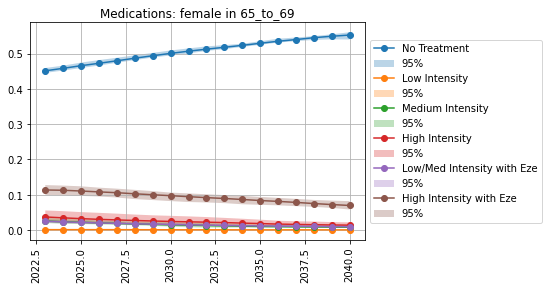

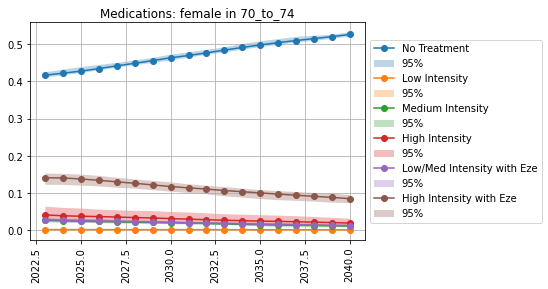

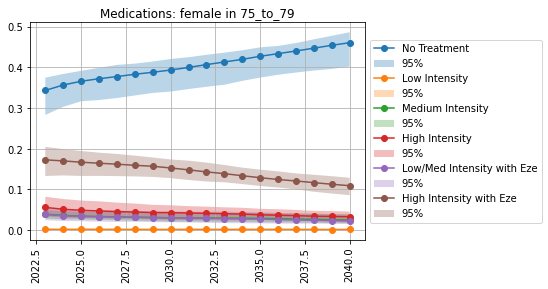

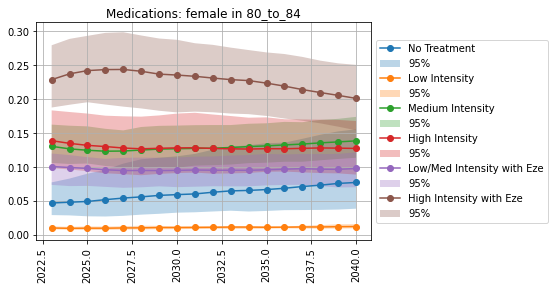

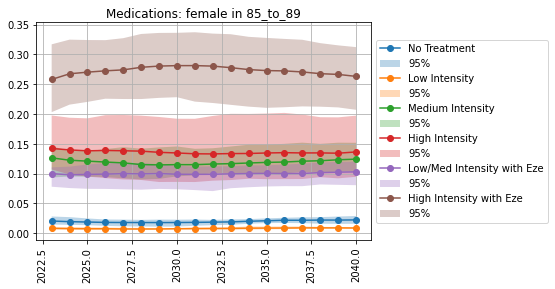

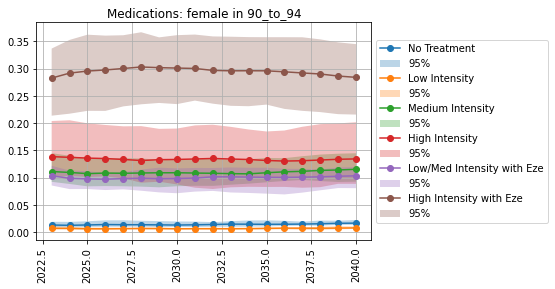

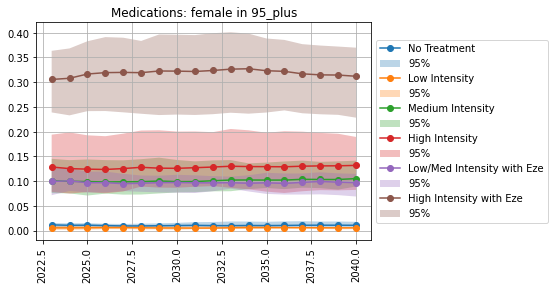

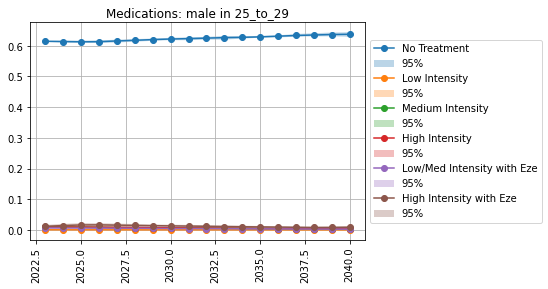

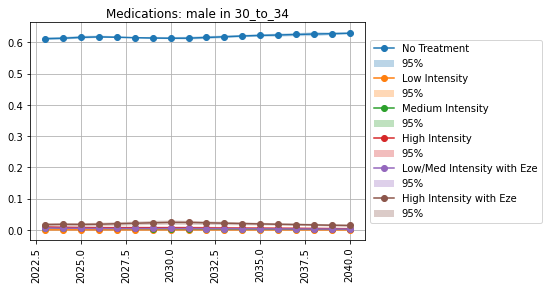

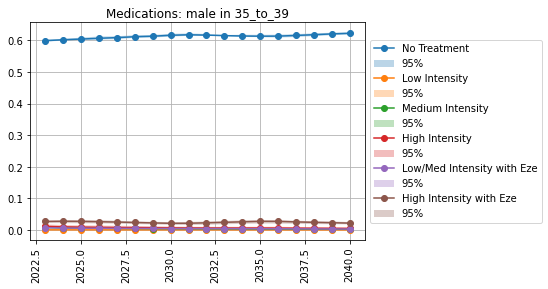

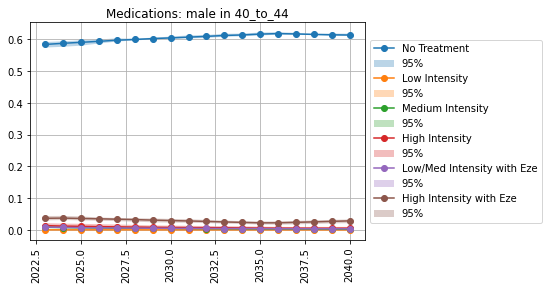

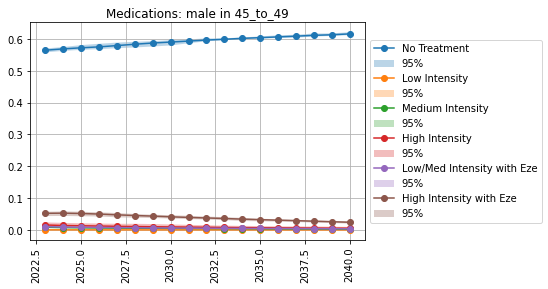

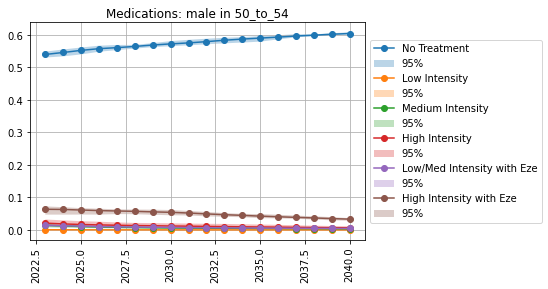

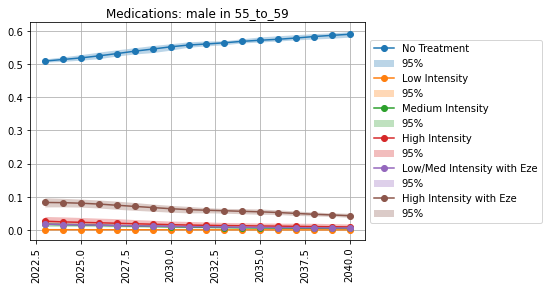

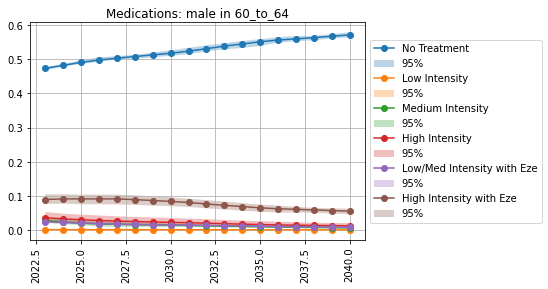

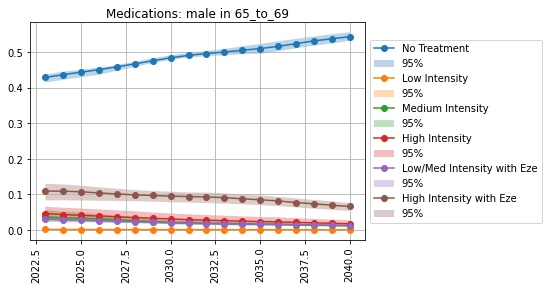

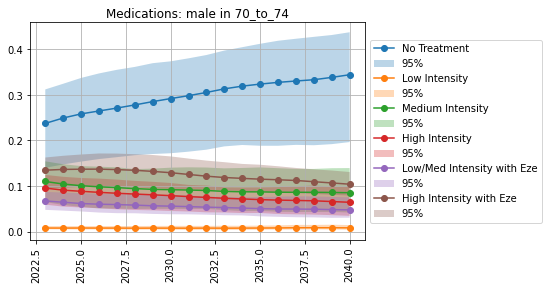

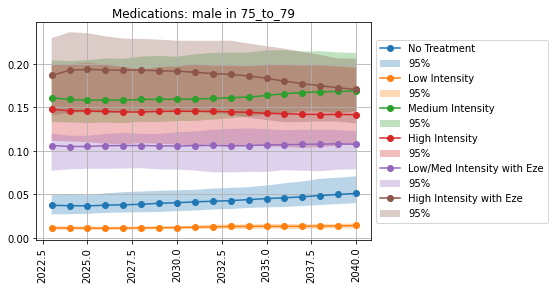

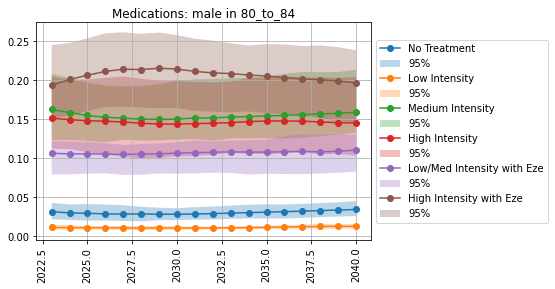

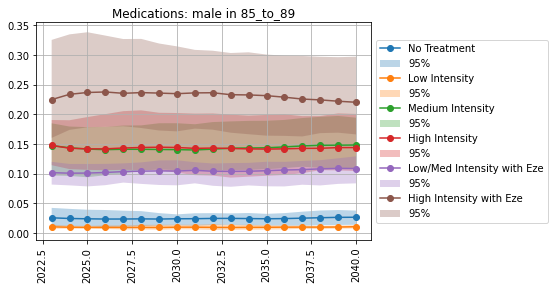

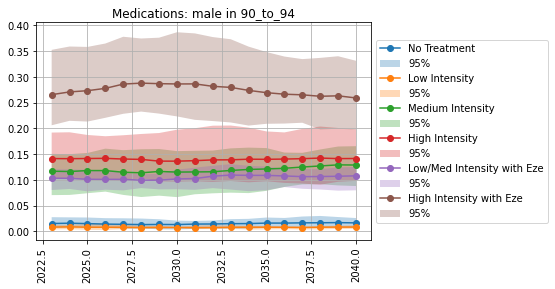

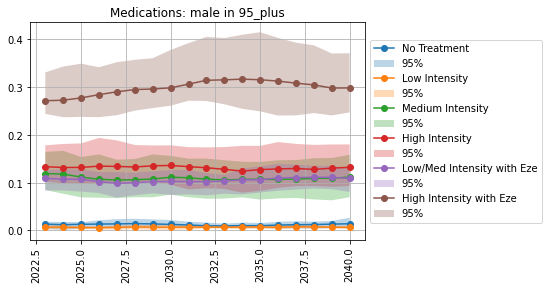

In [153]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        plt.fill_between(no_trt['year'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_intensity')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        plt.fill_between(one_half['year'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='medium_intensity')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        plt.fill_between(one_std['year'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_intensity')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        plt.fill_between(two_half['year'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_med_with_eze')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        plt.fill_between(two_std['year'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_with_eze')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        plt.fill_between(three_half['year'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
        plt.title(f'Medications: {sex} in {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', '95%', 'Low Intensity', '95%', 'Medium Intensity','95%','High Intensity', '95%','Low/Med Intensity with Eze', '95%','High Intensity with Eze', '95%'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()

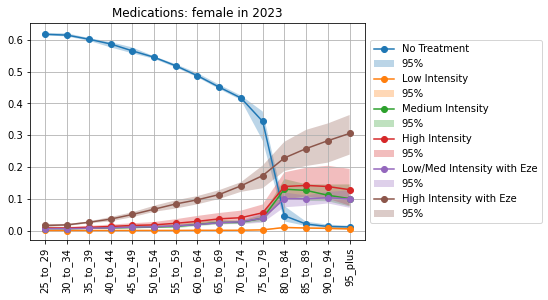

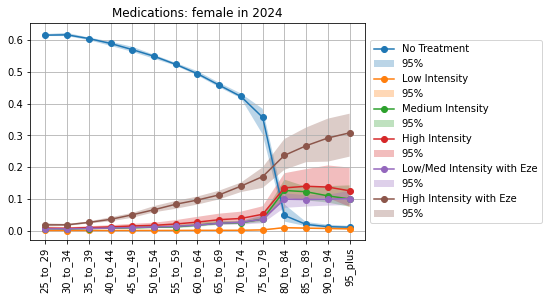

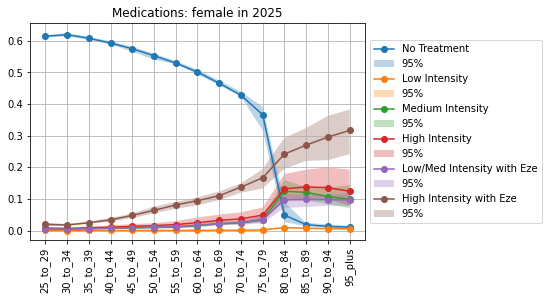

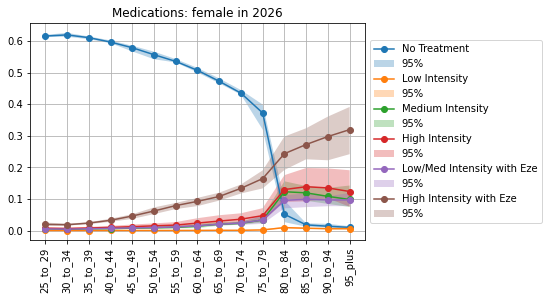

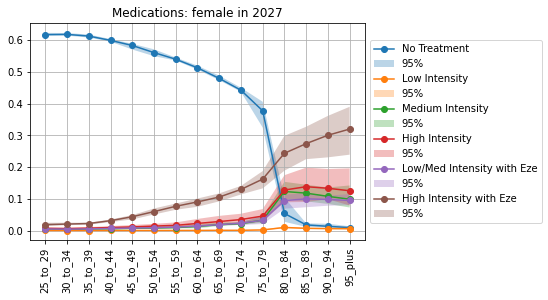

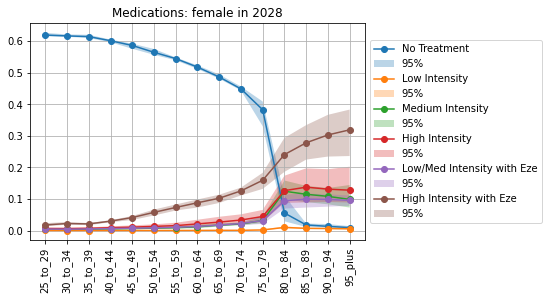

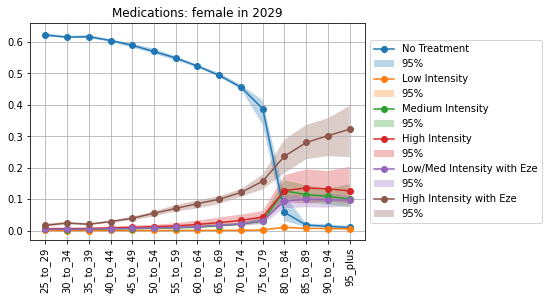

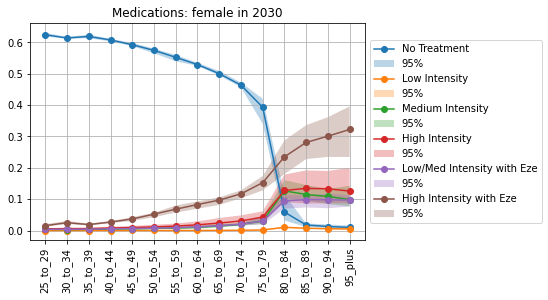

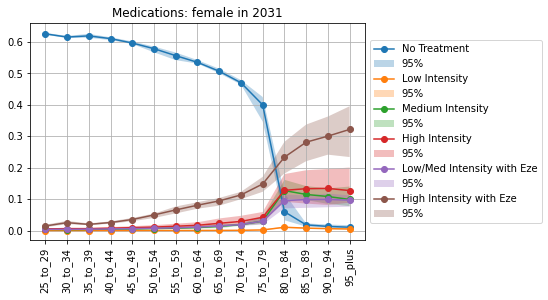

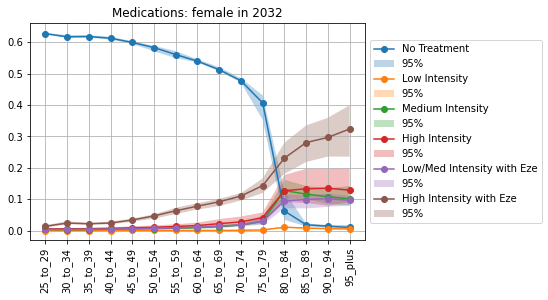

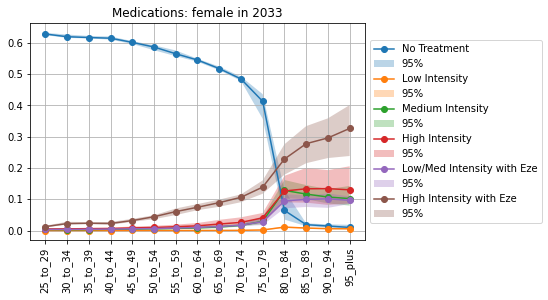

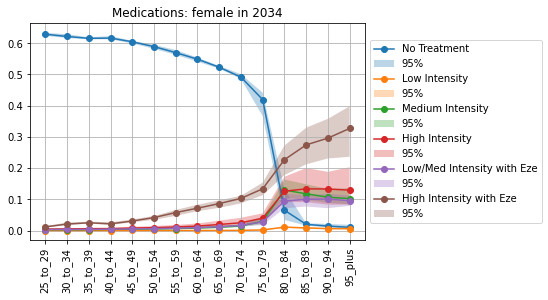

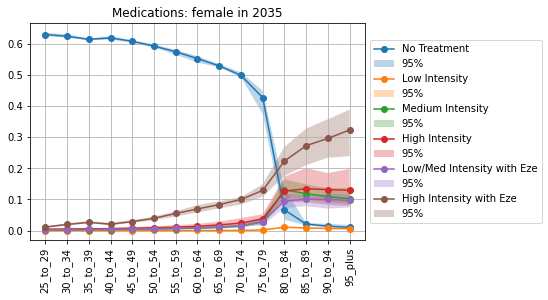

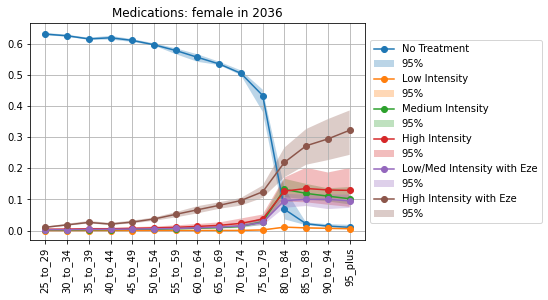

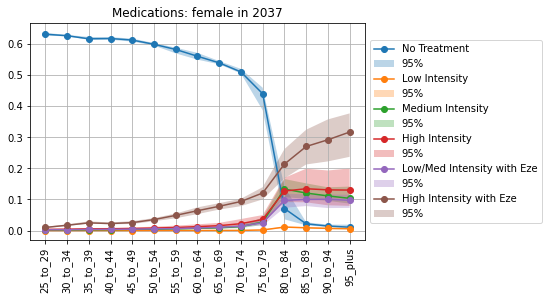

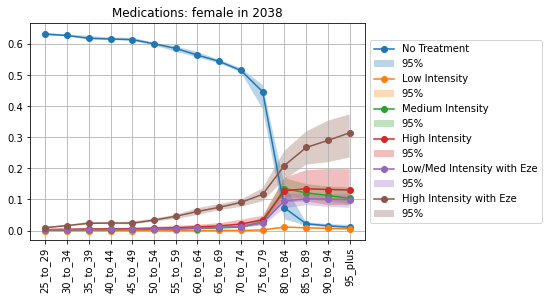

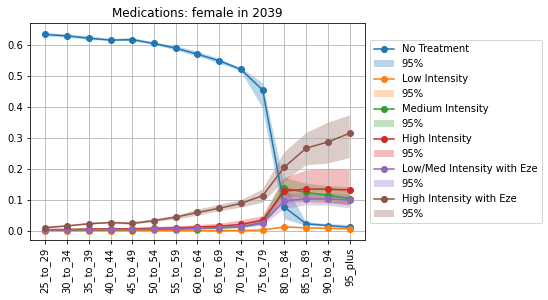

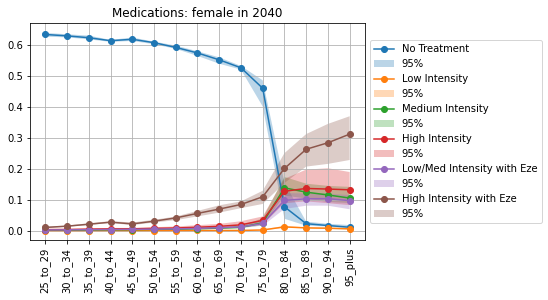

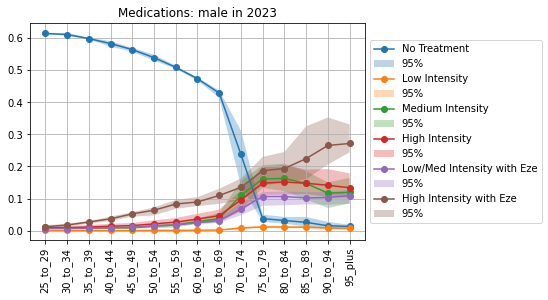

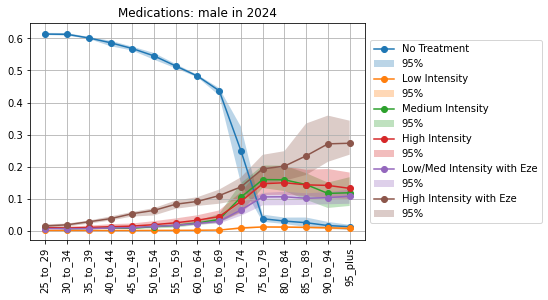

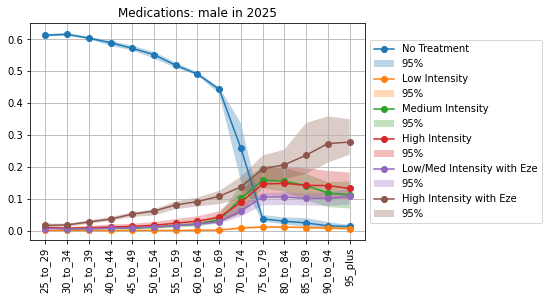

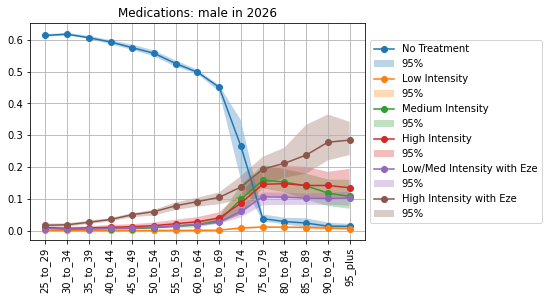

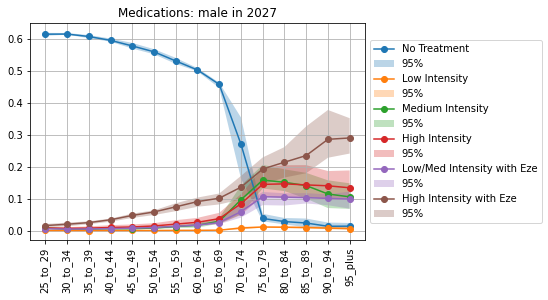

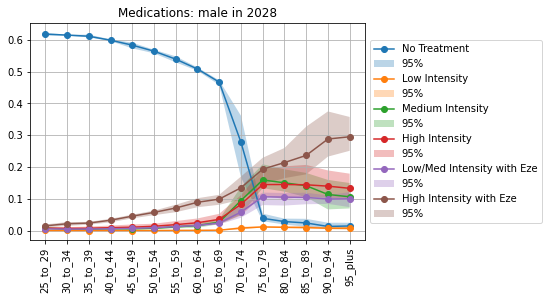

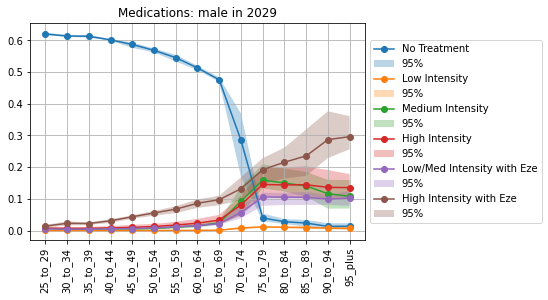

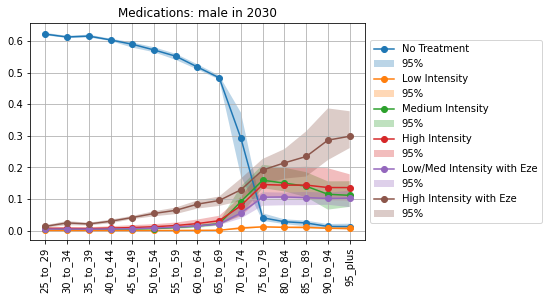

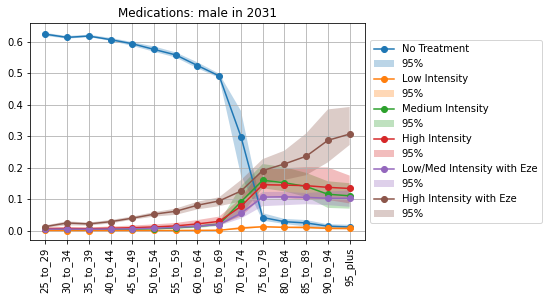

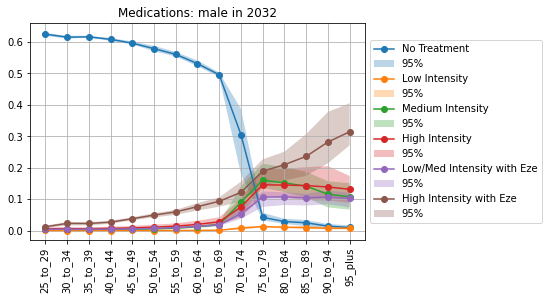

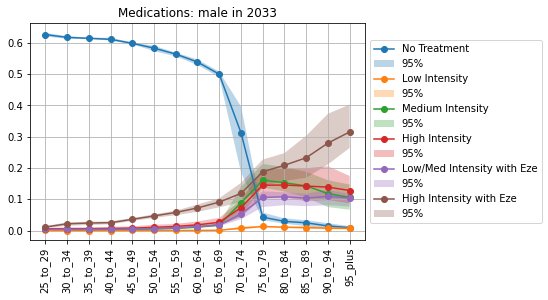

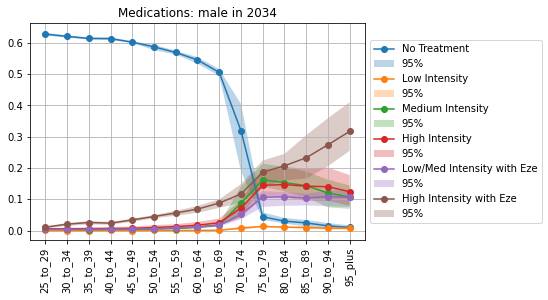

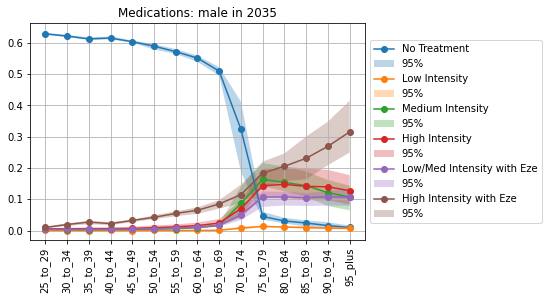

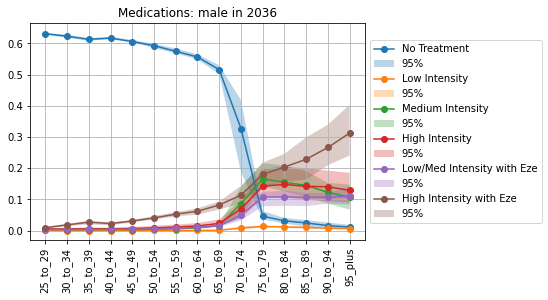

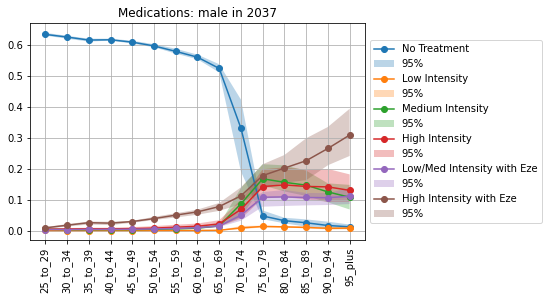

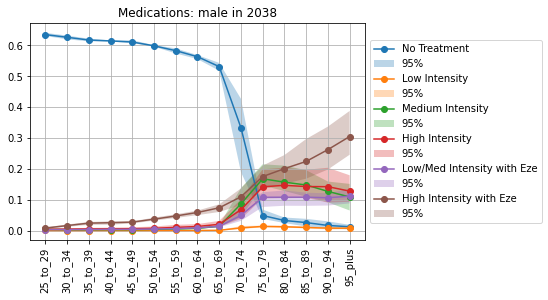

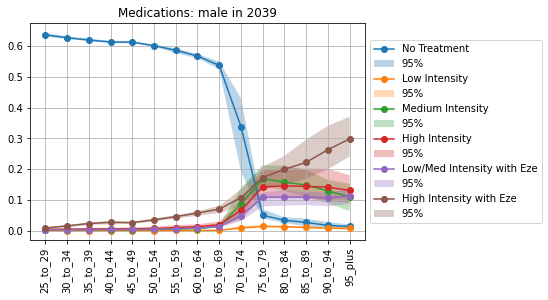

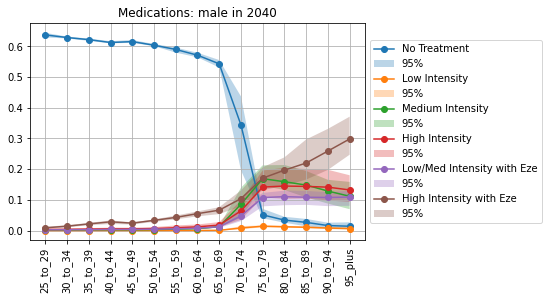

In [154]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for year in meds_adherent_rate_summ.year.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.ldlc_medication=='no_treatment')]
        plt.plot(no_trt['age'], no_trt['mean'], marker='o')
        plt.fill_between(no_trt['age'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.ldlc_medication=='low_intensity')]
        plt.plot(one_half['age'], one_half['mean'], marker='o')
        plt.fill_between(one_half['age'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.ldlc_medication=='medium_intensity')]
        plt.plot(one_std['age'], one_std['mean'], marker='o')
        plt.fill_between(one_std['age'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.ldlc_medication=='high_intensity')]
        plt.plot(two_half['age'], two_half['mean'], marker='o')
        plt.fill_between(two_half['age'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.ldlc_medication=='low_med_with_eze')]
        plt.plot(two_std['age'], two_std['mean'], marker='o')
        plt.fill_between(two_std['age'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.year==year) & (meds_adherent_rate_summ.ldlc_medication=='high_with_eze')]
        plt.plot(three_half['age'], three_half['mean'], marker='o')
        plt.fill_between(three_half['age'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
        plt.title(f'Medications: {sex} in {year}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', '95%', 'Low Intensity', '95%', 'Medium Intensity','95%','High Intensity', '95%','Low/Med Intensity with Eze', '95%','High Intensity with Eze', '95%'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()